# Importing

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [9]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220320_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220320_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    nitr = ds_bio.nitrate
    ammo = ds_bio.ammonium

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, nitr, ammo)


# Masking

In [10]:
def masking (depth, temp, saline, mask, sil, nitr, ammo):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    nitr= nitr.where(mask[0,depth]==1)
    ammo = ammo.where(mask[0,depth]==1)

    return (temp, saline, sil, nitr, ammo)

# SOM

In [11]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2.transpose(), predictions, clusters)


# Printing

In [12]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [13]:
def plotting (depth, clusters, unique, sil, nitr, ammo):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': sil[0,depth].y, 'x': sil[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')
    fig, ax = plt.subplots(2,2, figsize=(10, 15))
    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.1, 
        hspace=0.15)
        
    cmap = plt.get_cmap('Accent')
    cmap.set_bad('gray')
    sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    nitr[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
    ammo[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Silicones')
    ax[1,0].title.set_text('Nitrate')
    ax[1,1].title.set_text('Ammonium')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters, ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 5596 

The minimum temperature for cluster 0 is 6.23 degrees Celsius
The maximum temperature for cluster 0 is 9.76 degrees Celsius
The mean temperature for cluster 0 is 7.66 degrees Celsius 

The minimum salinity for cluster 0 is 22.13 g/kg
The maximum salinity for cluster 0 is 26.22 g/kg
The mean salinity for cluster 0 is 24.13 g/kg 


The amount of grid boxes for cluster 1 is 11935 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 9.52 degrees Celsius
The mean temperature for cluster 1 is 7.31 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 23.53 g/kg
The mean salinity for cluster 1 is 18.52 g/kg 


The amount of grid boxes for cluster 2 is 11128 

The minimum temperature for cluster 2 is 5.87 degrees Celsius
The maximum temperature for cluster 2 is 8.17 degrees Celsius
The mean temperature for cluster 2 is 7.62 degrees Celsius 

The 

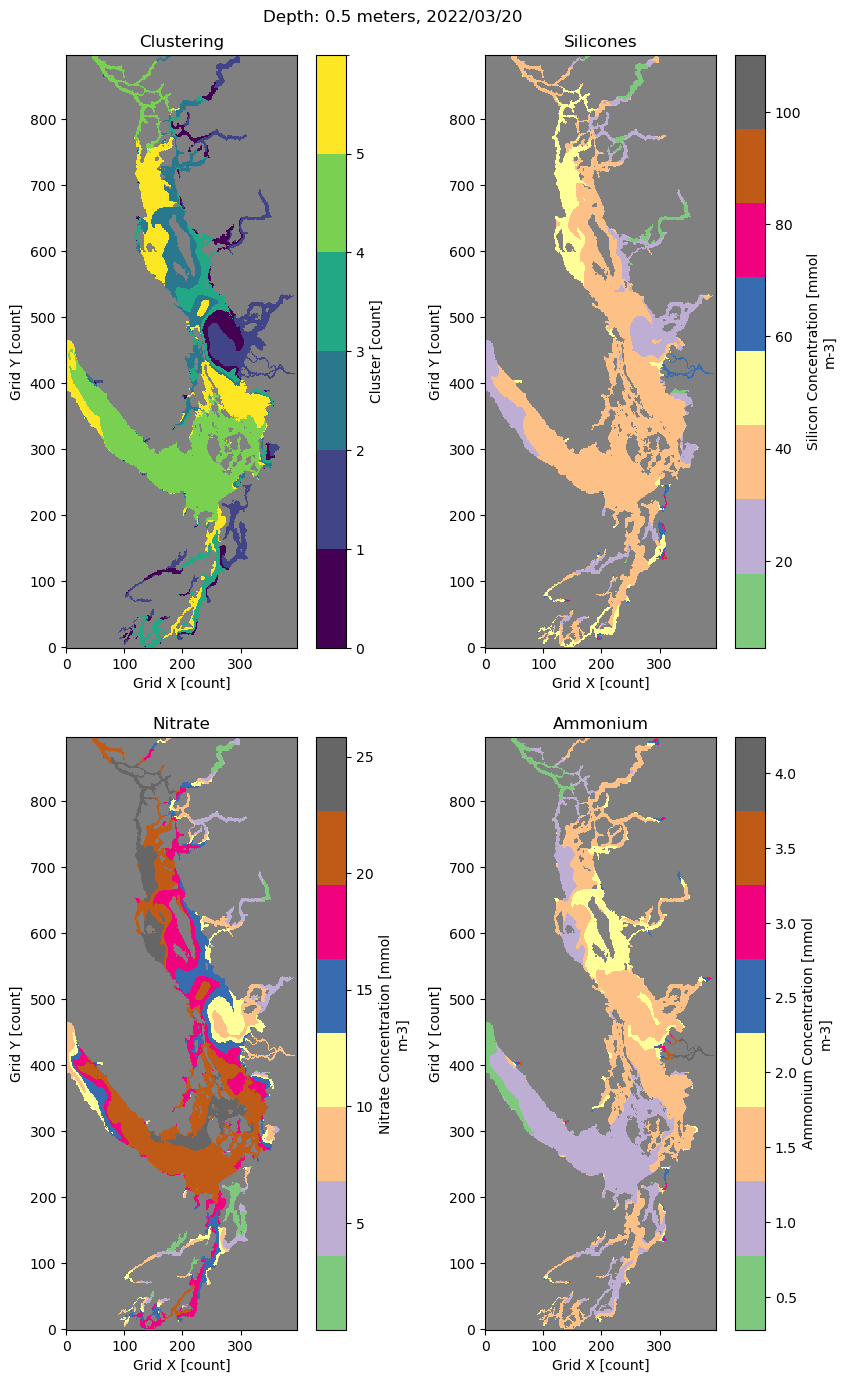

The amount of grid boxes for cluster 0 is 5953 

The minimum temperature for cluster 0 is 6.26 degrees Celsius
The maximum temperature for cluster 0 is 9.82 degrees Celsius
The mean temperature for cluster 0 is 7.8 degrees Celsius 

The minimum salinity for cluster 0 is 20.55 g/kg
The maximum salinity for cluster 0 is 25.08 g/kg
The mean salinity for cluster 0 is 23.72 g/kg 


The amount of grid boxes for cluster 1 is 10027 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 9.51 degrees Celsius
The mean temperature for cluster 1 is 7.35 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 24.0 g/kg
The mean salinity for cluster 1 is 18.48 g/kg 


The amount of grid boxes for cluster 2 is 8048 

The minimum temperature for cluster 2 is 7.63 degrees Celsius
The maximum temperature for cluster 2 is 9.92 degrees Celsius
The mean temperature for cluster 2 is 8.19 degrees Celsius 

The min

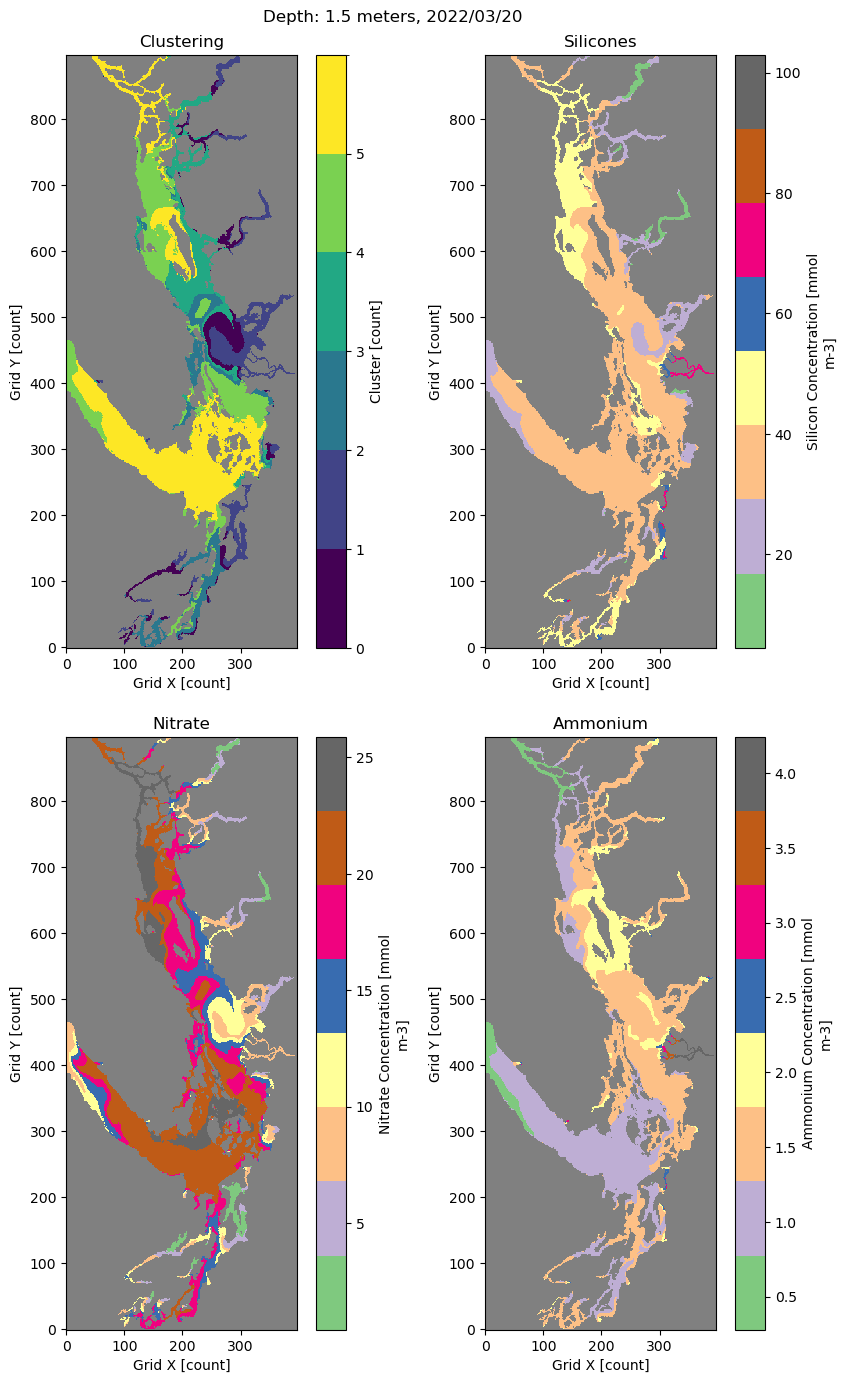

The amount of grid boxes for cluster 0 is 9270 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 9.81 degrees Celsius
The mean temperature for cluster 0 is 7.43 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 24.99 g/kg
The mean salinity for cluster 0 is 19.34 g/kg 


The amount of grid boxes for cluster 1 is 5761 

The minimum temperature for cluster 1 is 6.78 degrees Celsius
The maximum temperature for cluster 1 is 9.81 degrees Celsius
The mean temperature for cluster 1 is 7.97 degrees Celsius 

The minimum salinity for cluster 1 is 20.36 g/kg
The maximum salinity for cluster 1 is 25.58 g/kg
The mean salinity for cluster 1 is 24.23 g/kg 


The amount of grid boxes for cluster 2 is 11081 

The minimum temperature for cluster 2 is 5.88 degrees Celsius
The maximum temperature for cluster 2 is 7.94 degrees Celsius
The mean temperature for cluster 2 is 7.51 degrees Celsius 

The m

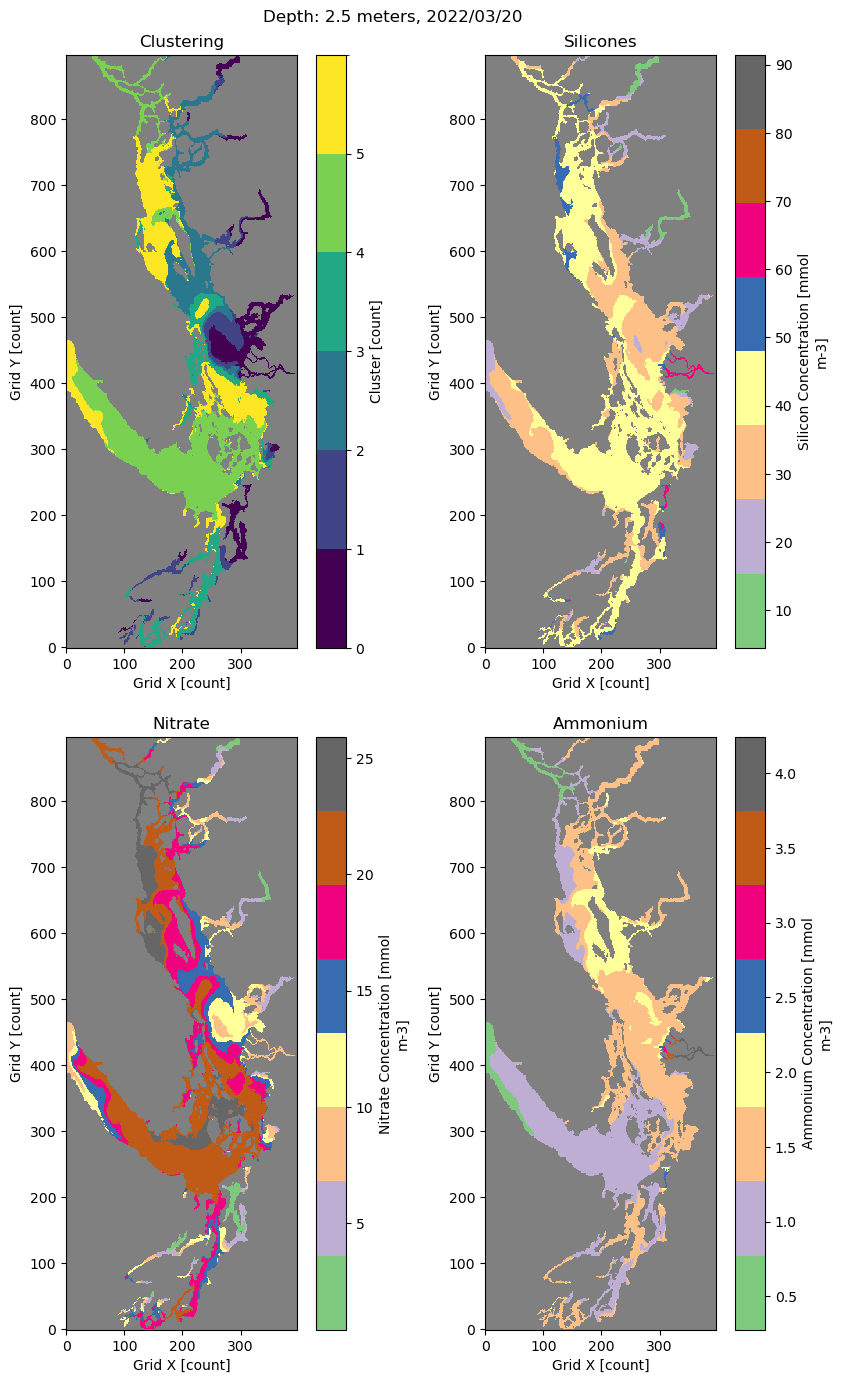

The amount of grid boxes for cluster 0 is 10156 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 10.03 degrees Celsius
The mean temperature for cluster 0 is 7.66 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.07 g/kg
The mean salinity for cluster 0 is 20.82 g/kg 


The amount of grid boxes for cluster 1 is 5967 

The minimum temperature for cluster 1 is 6.42 degrees Celsius
The maximum temperature for cluster 1 is 8.54 degrees Celsius
The mean temperature for cluster 1 is 7.48 degrees Celsius 

The minimum salinity for cluster 1 is 24.07 g/kg
The maximum salinity for cluster 1 is 27.14 g/kg
The mean salinity for cluster 1 is 25.69 g/kg 


The amount of grid boxes for cluster 2 is 10533 

The minimum temperature for cluster 2 is 7.49 degrees Celsius
The maximum temperature for cluster 2 is 10.09 degrees Celsius
The mean temperature for cluster 2 is 8.21 degrees Celsius 

Th

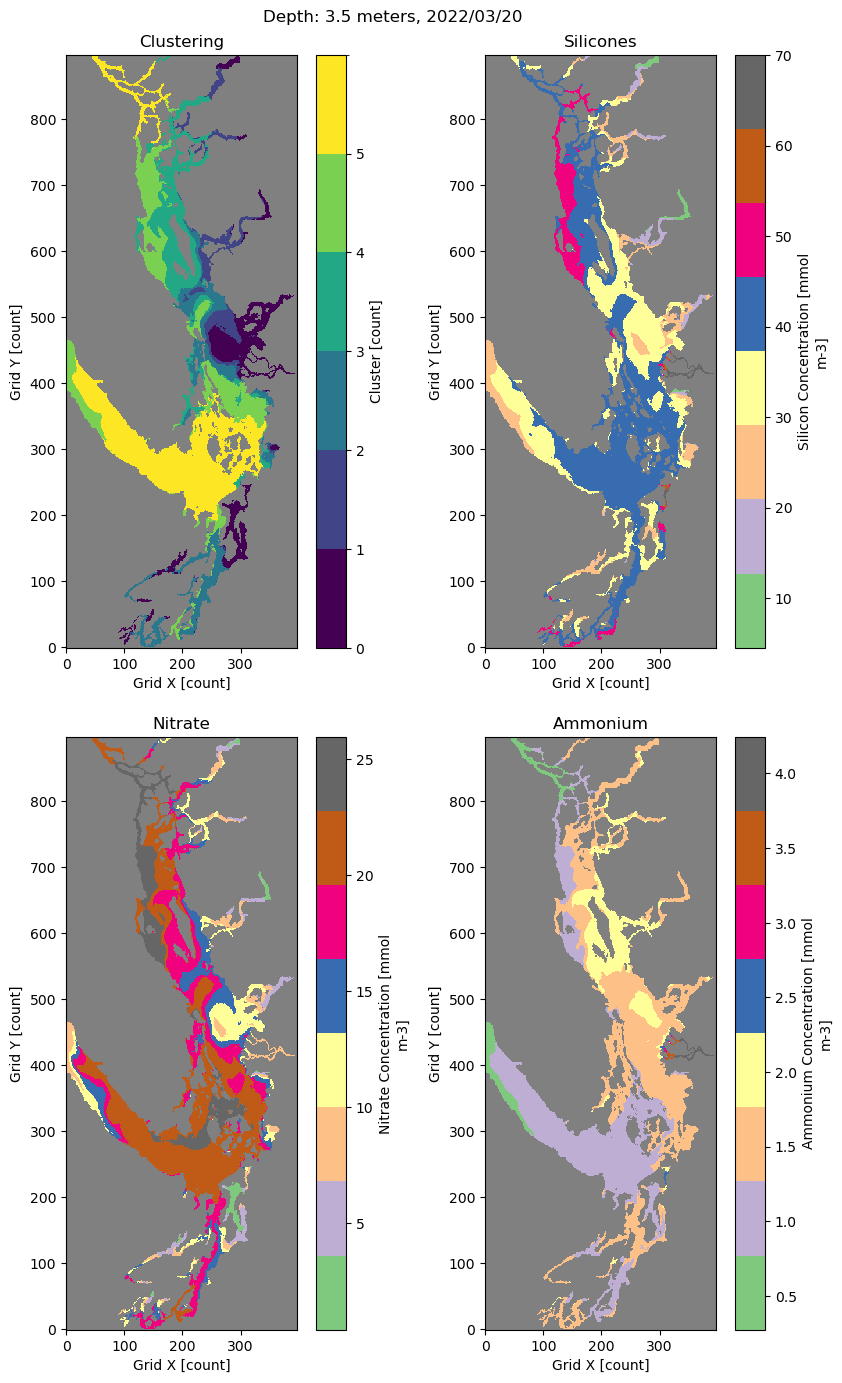

The amount of grid boxes for cluster 0 is 9384 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 9.38 degrees Celsius
The mean temperature for cluster 0 is 7.67 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.98 g/kg
The mean salinity for cluster 0 is 21.92 g/kg 


The amount of grid boxes for cluster 1 is 7765 

The minimum temperature for cluster 1 is 6.51 degrees Celsius
The maximum temperature for cluster 1 is 7.93 degrees Celsius
The mean temperature for cluster 1 is 7.45 degrees Celsius 

The minimum salinity for cluster 1 is 24.71 g/kg
The maximum salinity for cluster 1 is 27.7 g/kg
The mean salinity for cluster 1 is 26.54 g/kg 


The amount of grid boxes for cluster 2 is 10539 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.33 degrees Celsius 

The m

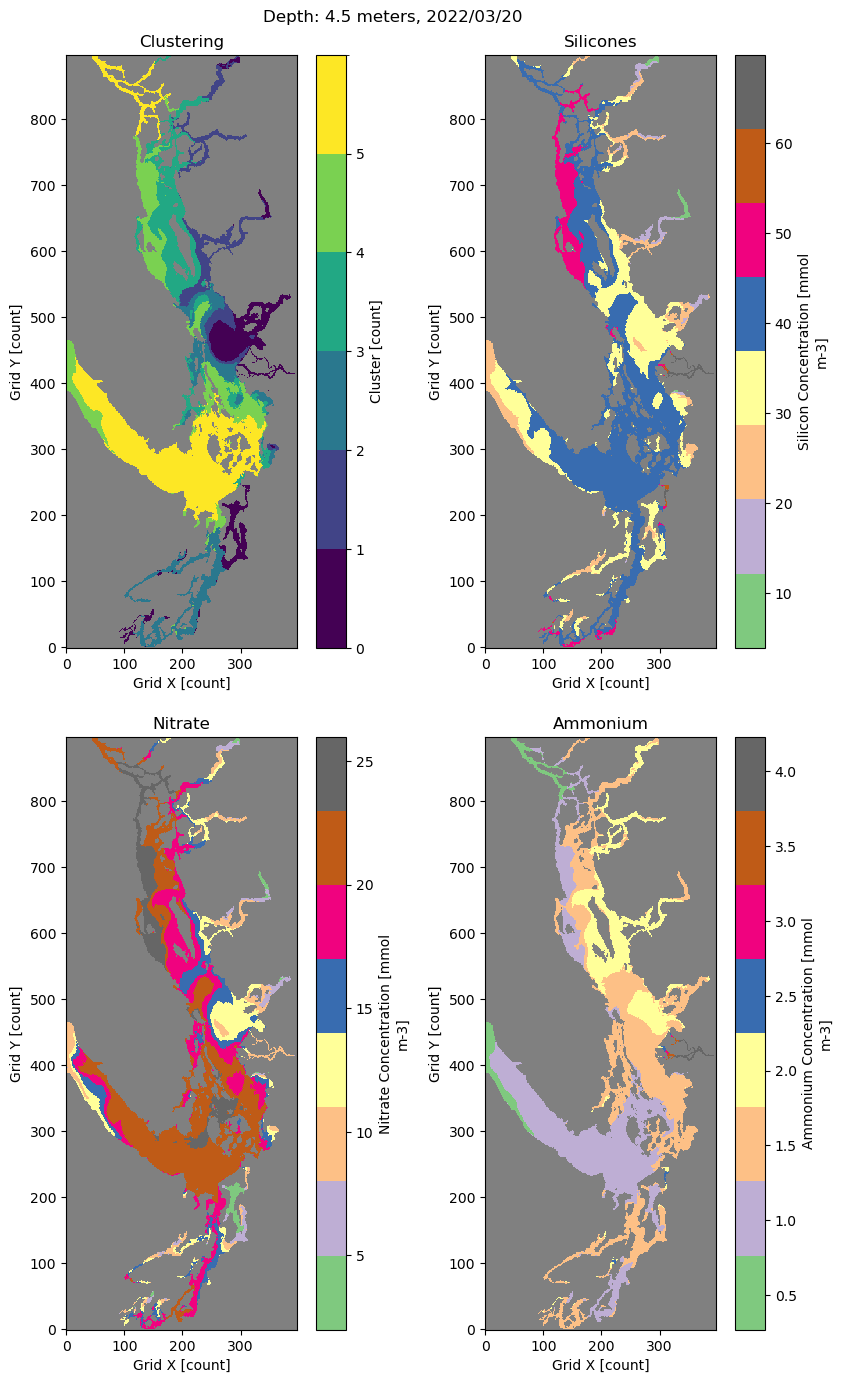

The amount of grid boxes for cluster 0 is 12799 

The minimum temperature for cluster 0 is 7.67 degrees Celsius
The maximum temperature for cluster 0 is 8.51 degrees Celsius
The mean temperature for cluster 0 is 7.98 degrees Celsius 

The minimum salinity for cluster 0 is 28.75 g/kg
The maximum salinity for cluster 0 is 30.21 g/kg
The mean salinity for cluster 0 is 29.24 g/kg 


The amount of grid boxes for cluster 1 is 24806 

The minimum temperature for cluster 1 is 6.06 degrees Celsius
The maximum temperature for cluster 1 is 7.97 degrees Celsius
The mean temperature for cluster 1 is 7.67 degrees Celsius 

The minimum salinity for cluster 1 is 28.87 g/kg
The maximum salinity for cluster 1 is 31.28 g/kg
The mean salinity for cluster 1 is 30.18 g/kg 


The amount of grid boxes for cluster 2 is 12283 

The minimum temperature for cluster 2 is 7.73 degrees Celsius
The maximum temperature for cluster 2 is 10.23 degrees Celsius
The mean temperature for cluster 2 is 8.12 degrees Celsius 



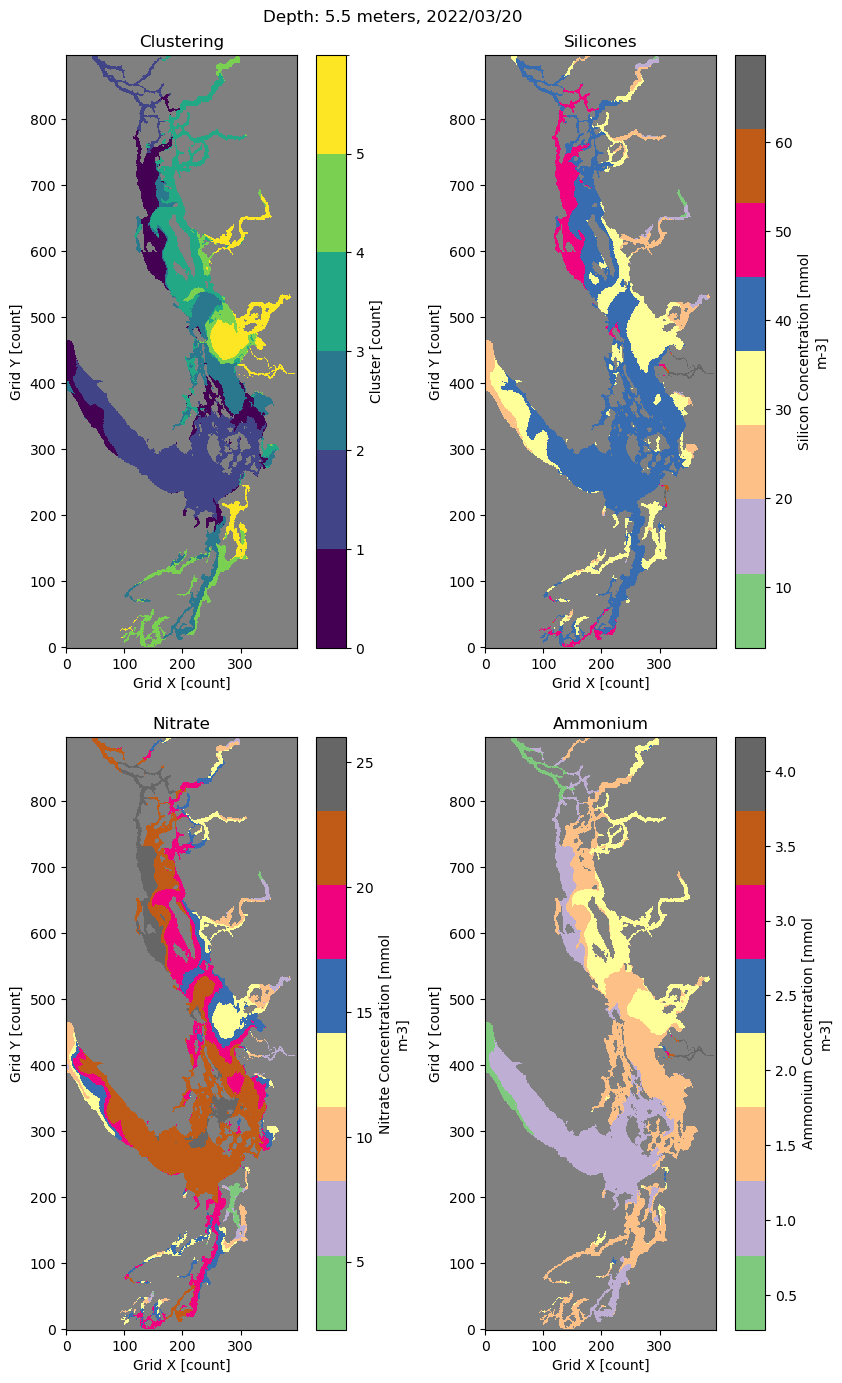

The amount of grid boxes for cluster 0 is 24892 

The minimum temperature for cluster 0 is 6.82 degrees Celsius
The maximum temperature for cluster 0 is 8.18 degrees Celsius
The mean temperature for cluster 0 is 7.72 degrees Celsius 

The minimum salinity for cluster 0 is 29.43 g/kg
The maximum salinity for cluster 0 is 31.29 g/kg
The mean salinity for cluster 0 is 30.23 g/kg 


The amount of grid boxes for cluster 1 is 4487 

The minimum temperature for cluster 1 is 5.74 degrees Celsius
The maximum temperature for cluster 1 is 7.89 degrees Celsius
The mean temperature for cluster 1 is 7.59 degrees Celsius 

The minimum salinity for cluster 1 is 28.69 g/kg
The maximum salinity for cluster 1 is 29.99 g/kg
The mean salinity for cluster 1 is 29.31 g/kg 


The amount of grid boxes for cluster 2 is 15930 

The minimum temperature for cluster 2 is 7.7 degrees Celsius
The maximum temperature for cluster 2 is 8.52 degrees Celsius
The mean temperature for cluster 2 is 7.98 degrees Celsius 

The

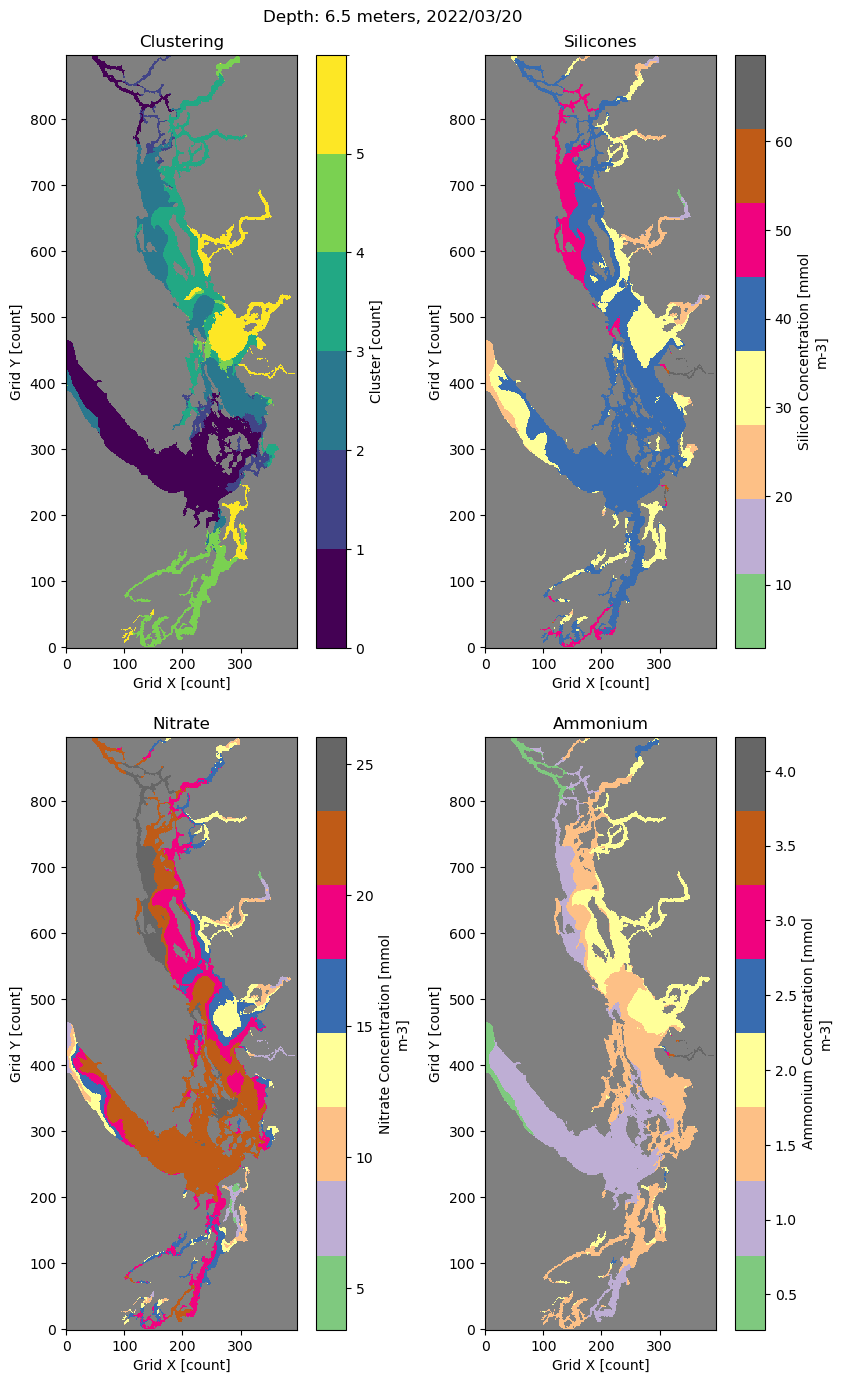

The amount of grid boxes for cluster 0 is 9272 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 8.74 degrees Celsius
The mean temperature for cluster 0 is 7.5 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.64 g/kg
The mean salinity for cluster 0 is 25.38 g/kg 


The amount of grid boxes for cluster 1 is 9292 

The minimum temperature for cluster 1 is 7.86 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 8.61 degrees Celsius 

The minimum salinity for cluster 1 is 23.55 g/kg
The maximum salinity for cluster 1 is 29.12 g/kg
The mean salinity for cluster 1 is 27.39 g/kg 


The amount of grid boxes for cluster 2 is 15302 

The minimum temperature for cluster 2 is 6.98 degrees Celsius
The maximum temperature for cluster 2 is 7.94 degrees Celsius
The mean temperature for cluster 2 is 7.59 degrees Celsius 

The m

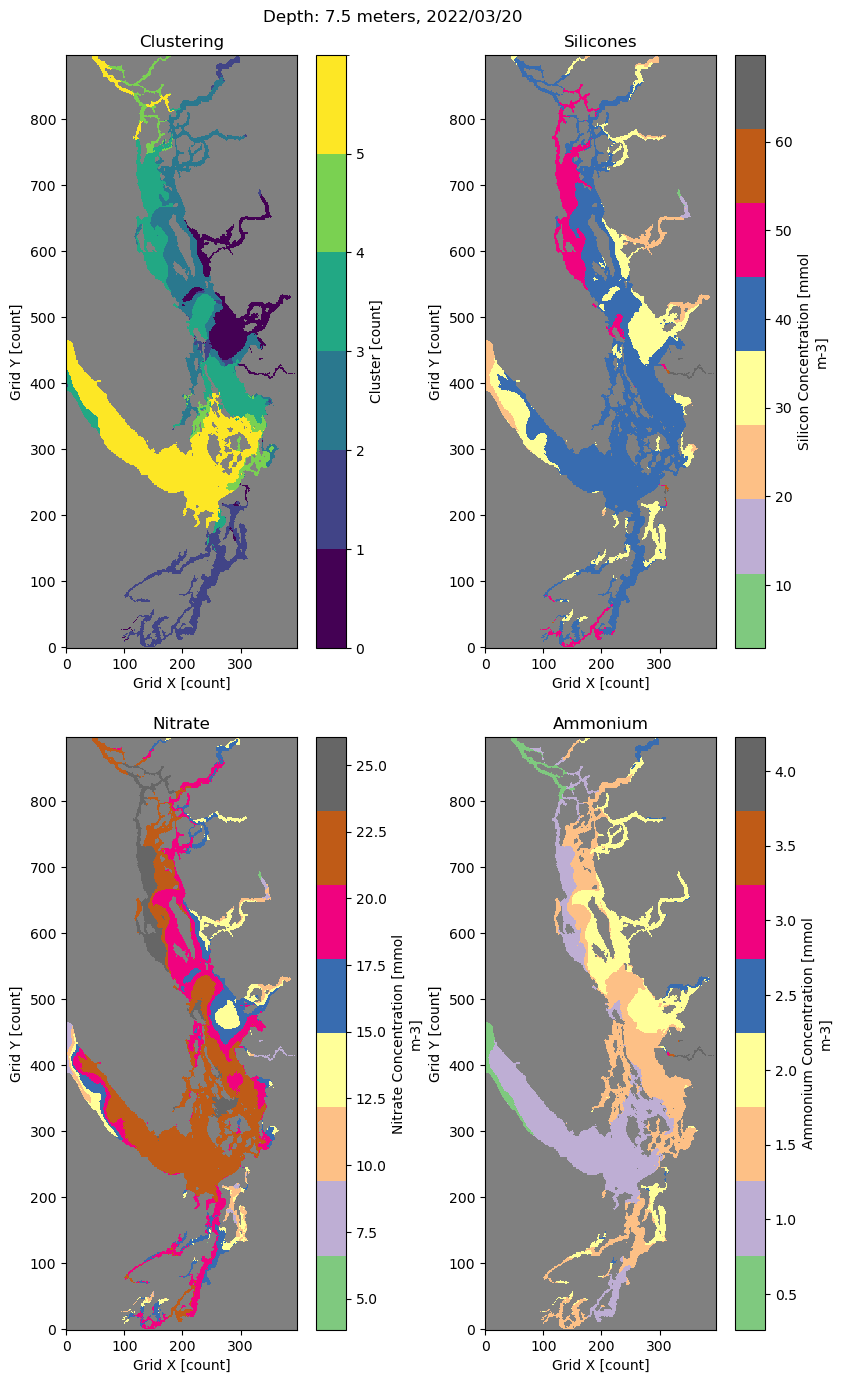

The amount of grid boxes for cluster 0 is 10698 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 8.63 degrees Celsius
The mean temperature for cluster 0 is 7.5 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.97 g/kg
The mean salinity for cluster 0 is 26.24 g/kg 


The amount of grid boxes for cluster 1 is 9260 

The minimum temperature for cluster 1 is 7.86 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 8.63 degrees Celsius 

The minimum salinity for cluster 1 is 22.88 g/kg
The maximum salinity for cluster 1 is 29.21 g/kg
The mean salinity for cluster 1 is 27.65 g/kg 


The amount of grid boxes for cluster 2 is 14376 

The minimum temperature for cluster 2 is 7.07 degrees Celsius
The maximum temperature for cluster 2 is 7.85 degrees Celsius
The mean temperature for cluster 2 is 7.61 degrees Celsius 

The 

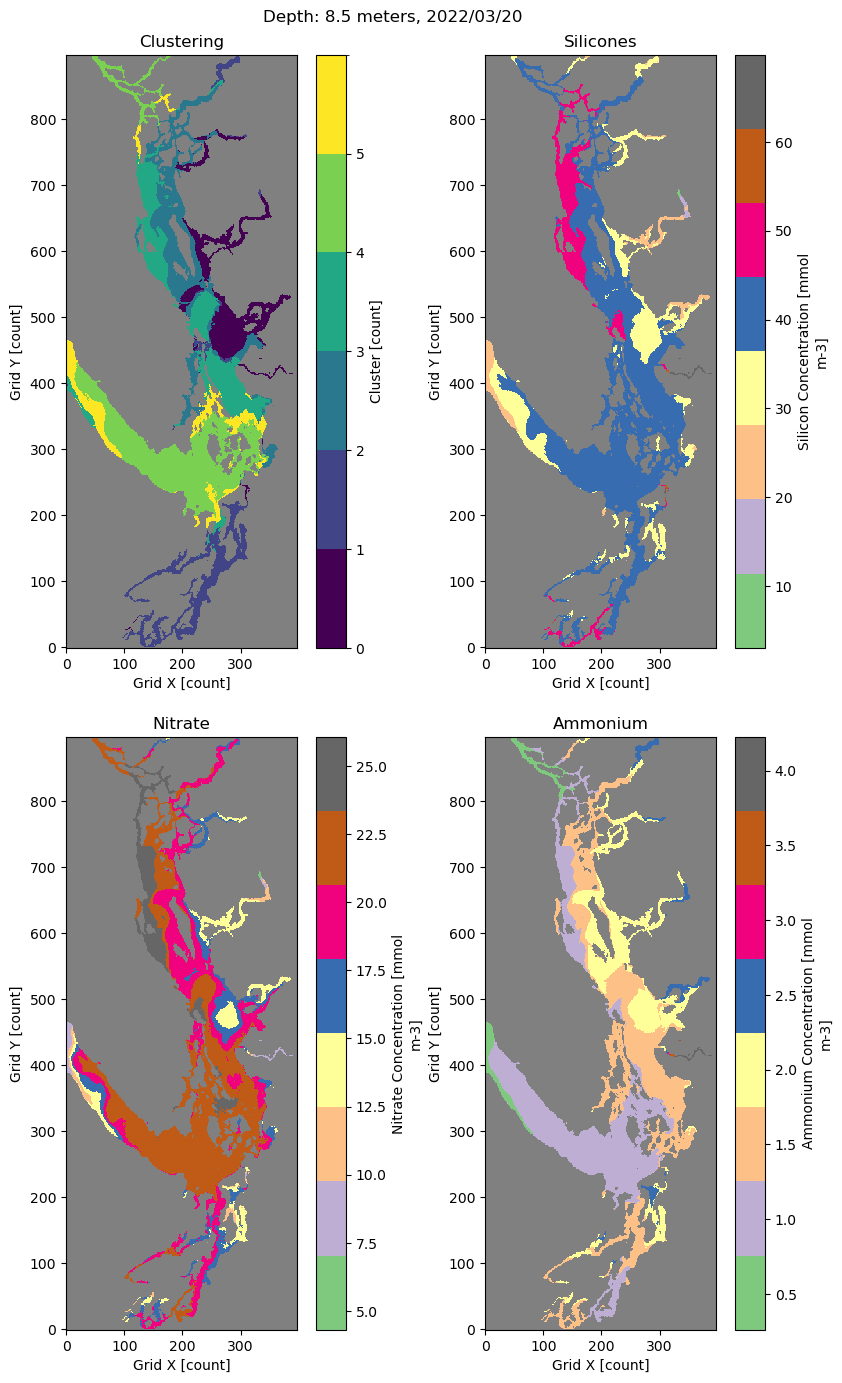

The amount of grid boxes for cluster 0 is 24810 

The minimum temperature for cluster 0 is 6.22 degrees Celsius
The maximum temperature for cluster 0 is 7.96 degrees Celsius
The mean temperature for cluster 0 is 7.67 degrees Celsius 

The minimum salinity for cluster 0 is 29.21 g/kg
The maximum salinity for cluster 0 is 31.31 g/kg
The mean salinity for cluster 0 is 30.25 g/kg 


The amount of grid boxes for cluster 1 is 5475 

The minimum temperature for cluster 1 is 7.79 degrees Celsius
The maximum temperature for cluster 1 is 8.31 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 29.04 g/kg
The maximum salinity for cluster 1 is 30.36 g/kg
The mean salinity for cluster 1 is 29.53 g/kg 


The amount of grid boxes for cluster 2 is 11627 

The minimum temperature for cluster 2 is 7.41 degrees Celsius
The maximum temperature for cluster 2 is 7.99 degrees Celsius
The mean temperature for cluster 2 is 7.81 degrees Celsius 

The

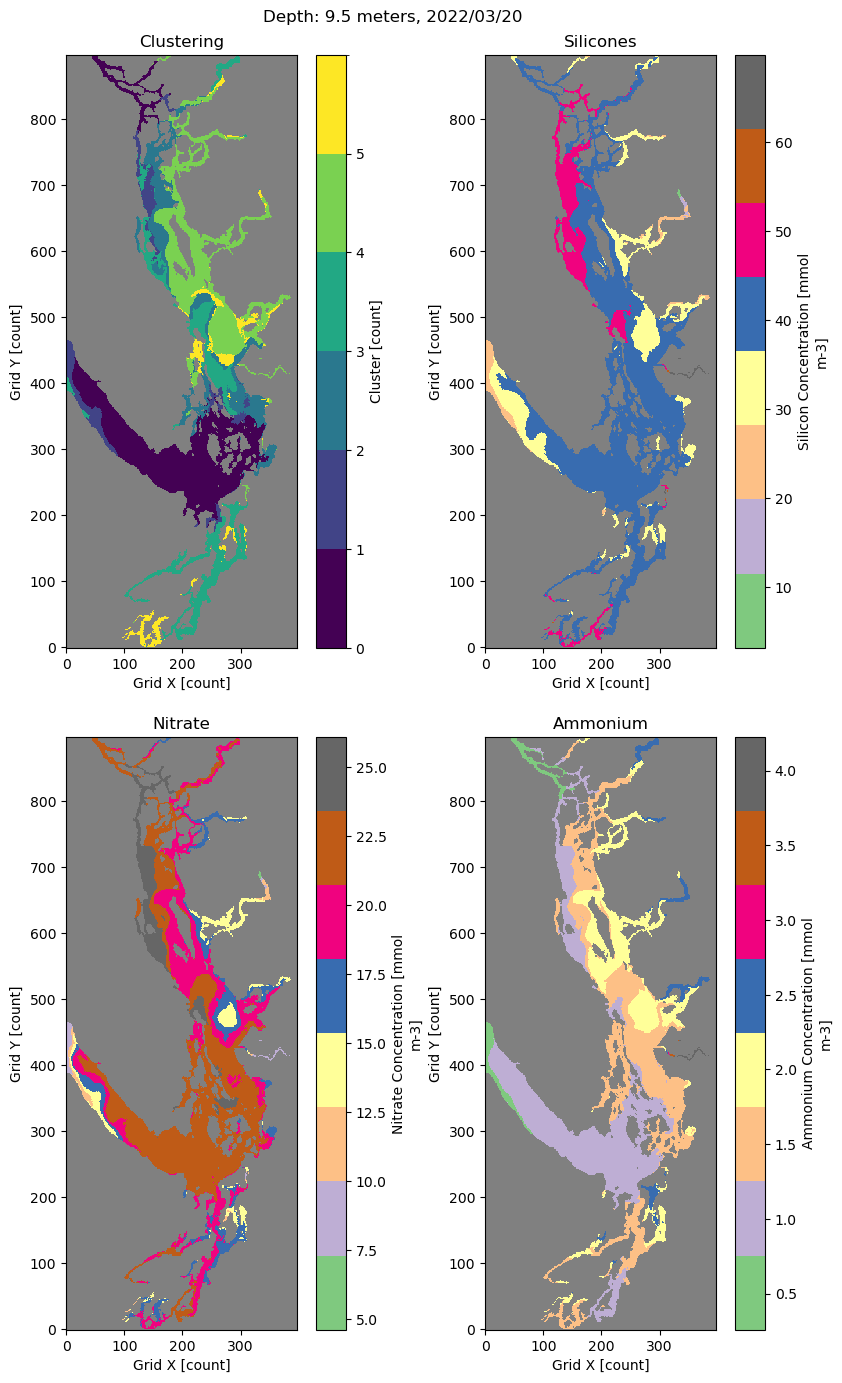

The amount of grid boxes for cluster 0 is 9440 

The minimum temperature for cluster 0 is 7.89 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.66 degrees Celsius 

The minimum salinity for cluster 0 is 22.65 g/kg
The maximum salinity for cluster 0 is 29.38 g/kg
The mean salinity for cluster 0 is 28.07 g/kg 


The amount of grid boxes for cluster 1 is 11315 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 8.39 degrees Celsius
The mean temperature for cluster 1 is 7.51 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.31 g/kg
The mean salinity for cluster 1 is 27.19 g/kg 


The amount of grid boxes for cluster 2 is 14974 

The minimum temperature for cluster 2 is 7.84 degrees Celsius
The maximum temperature for cluster 2 is 8.54 degrees Celsius
The mean temperature for cluster 2 is 8.02 degrees Celsius 

The

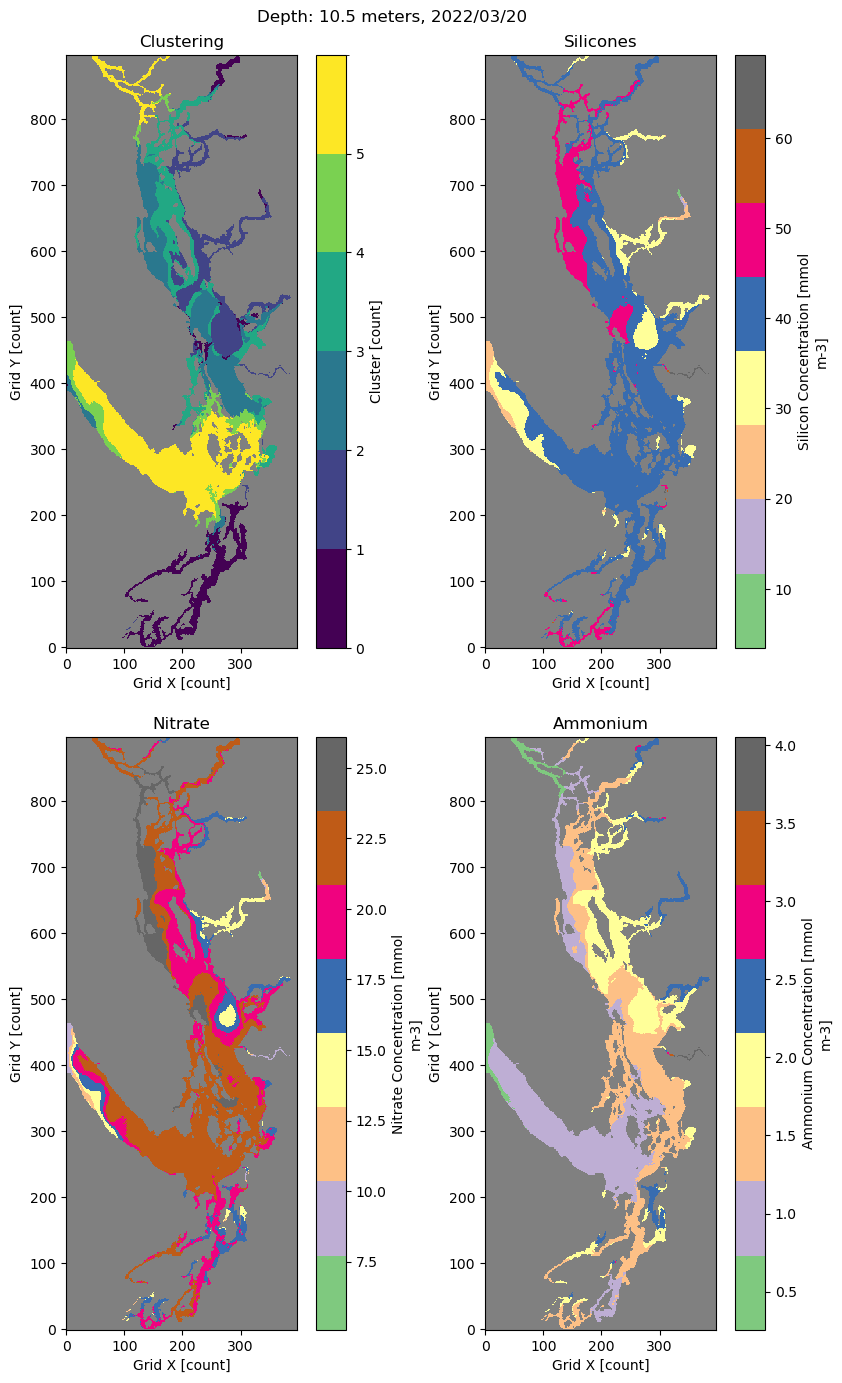

The amount of grid boxes for cluster 0 is 10486 

The minimum temperature for cluster 0 is 8.06 degrees Celsius
The maximum temperature for cluster 0 is 10.2 degrees Celsius
The mean temperature for cluster 0 is 8.64 degrees Celsius 

The minimum salinity for cluster 0 is 24.72 g/kg
The maximum salinity for cluster 0 is 29.81 g/kg
The mean salinity for cluster 0 is 28.35 g/kg 


The amount of grid boxes for cluster 1 is 5116 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 8.69 degrees Celsius
The mean temperature for cluster 1 is 7.72 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.54 g/kg
The mean salinity for cluster 1 is 26.81 g/kg 


The amount of grid boxes for cluster 2 is 14578 

The minimum temperature for cluster 2 is 7.77 degrees Celsius
The maximum temperature for cluster 2 is 8.27 degrees Celsius
The mean temperature for cluster 2 is 8.0 degrees Celsius 

The m

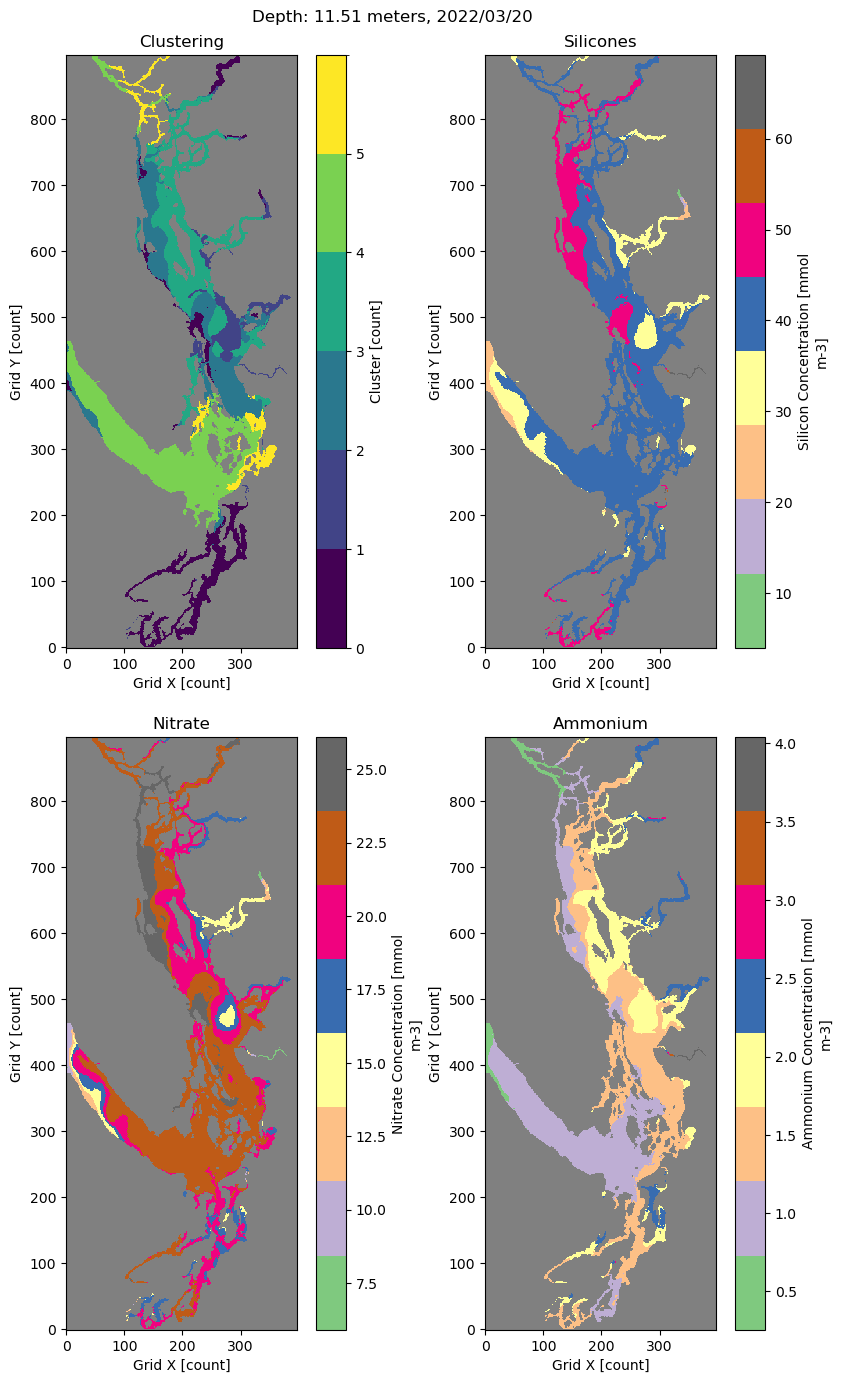

The amount of grid boxes for cluster 0 is 3714 

The minimum temperature for cluster 0 is 7.87 degrees Celsius
The maximum temperature for cluster 0 is 9.15 degrees Celsius
The mean temperature for cluster 0 is 8.21 degrees Celsius 

The minimum salinity for cluster 0 is 20.64 g/kg
The maximum salinity for cluster 0 is 28.73 g/kg
The mean salinity for cluster 0 is 27.83 g/kg 


The amount of grid boxes for cluster 1 is 15820 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 8.26 degrees Celsius
The mean temperature for cluster 1 is 7.54 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.8 g/kg
The mean salinity for cluster 1 is 27.86 g/kg 


The amount of grid boxes for cluster 2 is 15799 

The minimum temperature for cluster 2 is 7.99 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.42 degrees Celsius 

The 

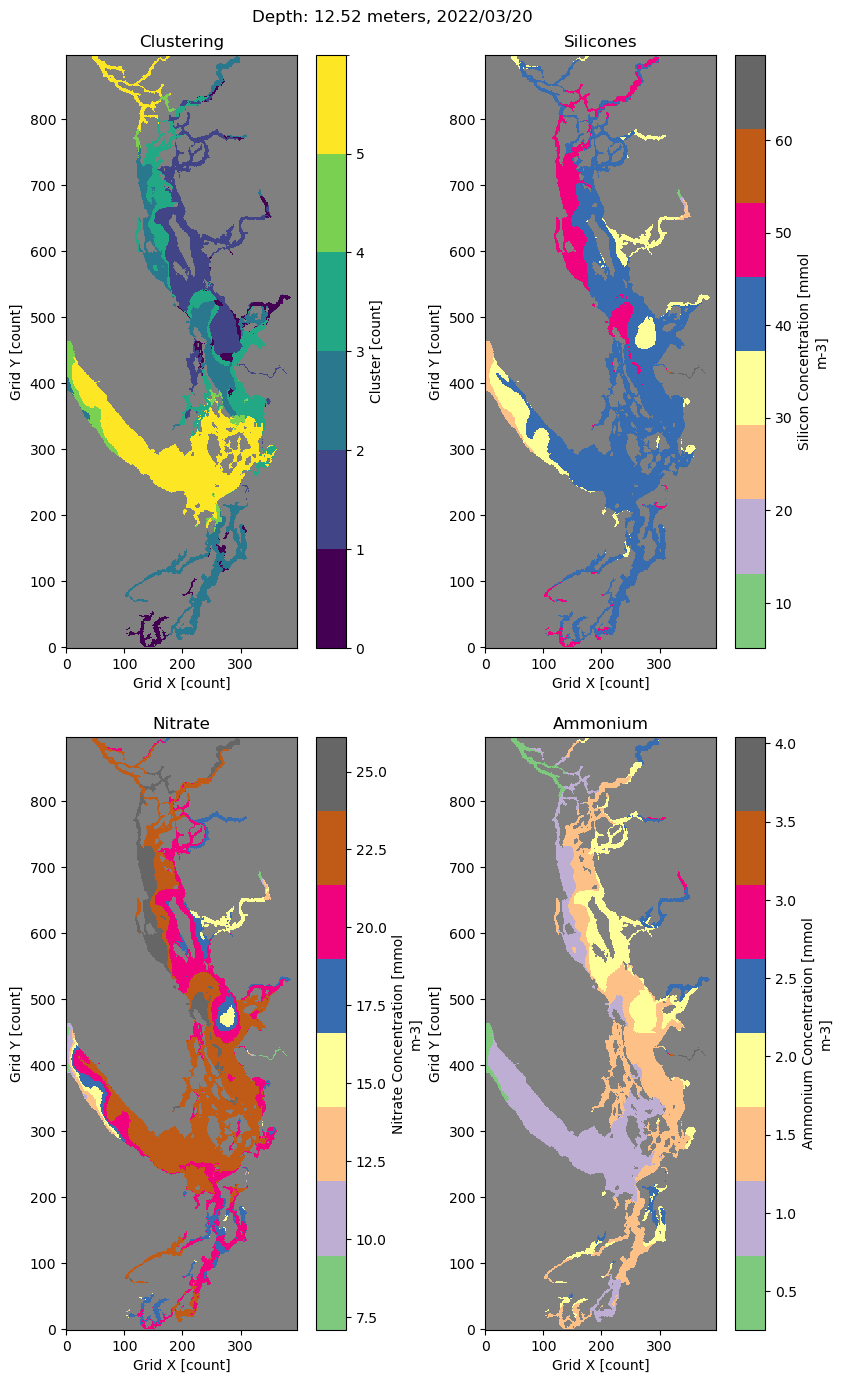

The amount of grid boxes for cluster 0 is 12458 

The minimum temperature for cluster 0 is 7.97 degrees Celsius
The maximum temperature for cluster 0 is 10.18 degrees Celsius
The mean temperature for cluster 0 is 8.54 degrees Celsius 

The minimum salinity for cluster 0 is 26.07 g/kg
The maximum salinity for cluster 0 is 30.26 g/kg
The mean salinity for cluster 0 is 28.94 g/kg 


The amount of grid boxes for cluster 1 is 24047 

The minimum temperature for cluster 1 is 6.86 degrees Celsius
The maximum temperature for cluster 1 is 8.12 degrees Celsius
The mean temperature for cluster 1 is 7.7 degrees Celsius 

The minimum salinity for cluster 1 is 29.54 g/kg
The maximum salinity for cluster 1 is 31.33 g/kg
The mean salinity for cluster 1 is 30.35 g/kg 


The amount of grid boxes for cluster 2 is 11931 

The minimum temperature for cluster 2 is 7.88 degrees Celsius
The maximum temperature for cluster 2 is 9.07 degrees Celsius
The mean temperature for cluster 2 is 8.07 degrees Celsius 

T

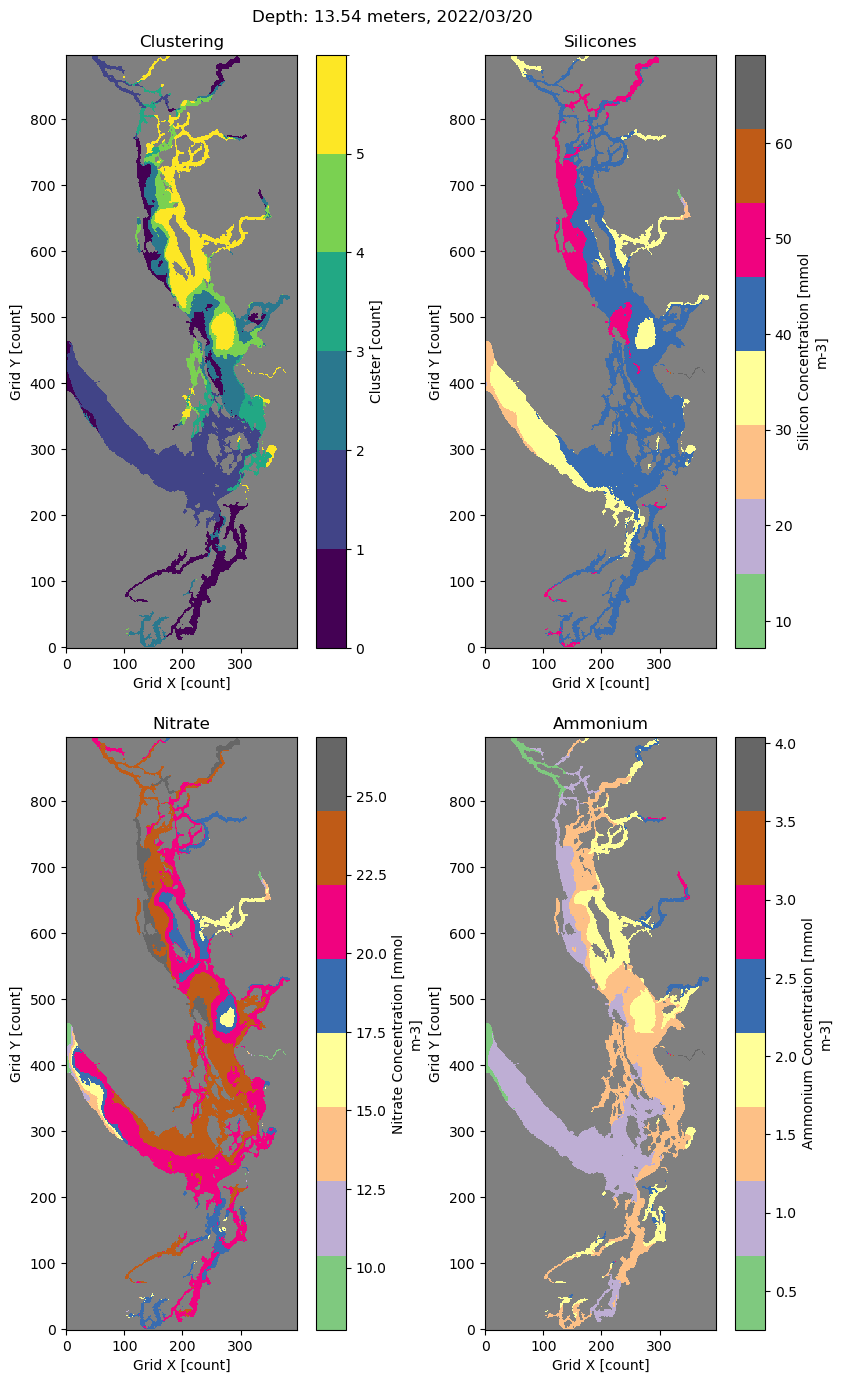

The amount of grid boxes for cluster 0 is 16431 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 8.3 degrees Celsius
The mean temperature for cluster 0 is 7.58 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.03 g/kg
The mean salinity for cluster 0 is 28.17 g/kg 


The amount of grid boxes for cluster 1 is 4916 

The minimum temperature for cluster 1 is 5.92 degrees Celsius
The maximum temperature for cluster 1 is 7.79 degrees Celsius
The mean temperature for cluster 1 is 7.52 degrees Celsius 

The minimum salinity for cluster 1 is 29.01 g/kg
The maximum salinity for cluster 1 is 30.83 g/kg
The mean salinity for cluster 1 is 29.66 g/kg 


The amount of grid boxes for cluster 2 is 12100 

The minimum temperature for cluster 2 is 7.74 degrees Celsius
The maximum temperature for cluster 2 is 8.1 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

The mi

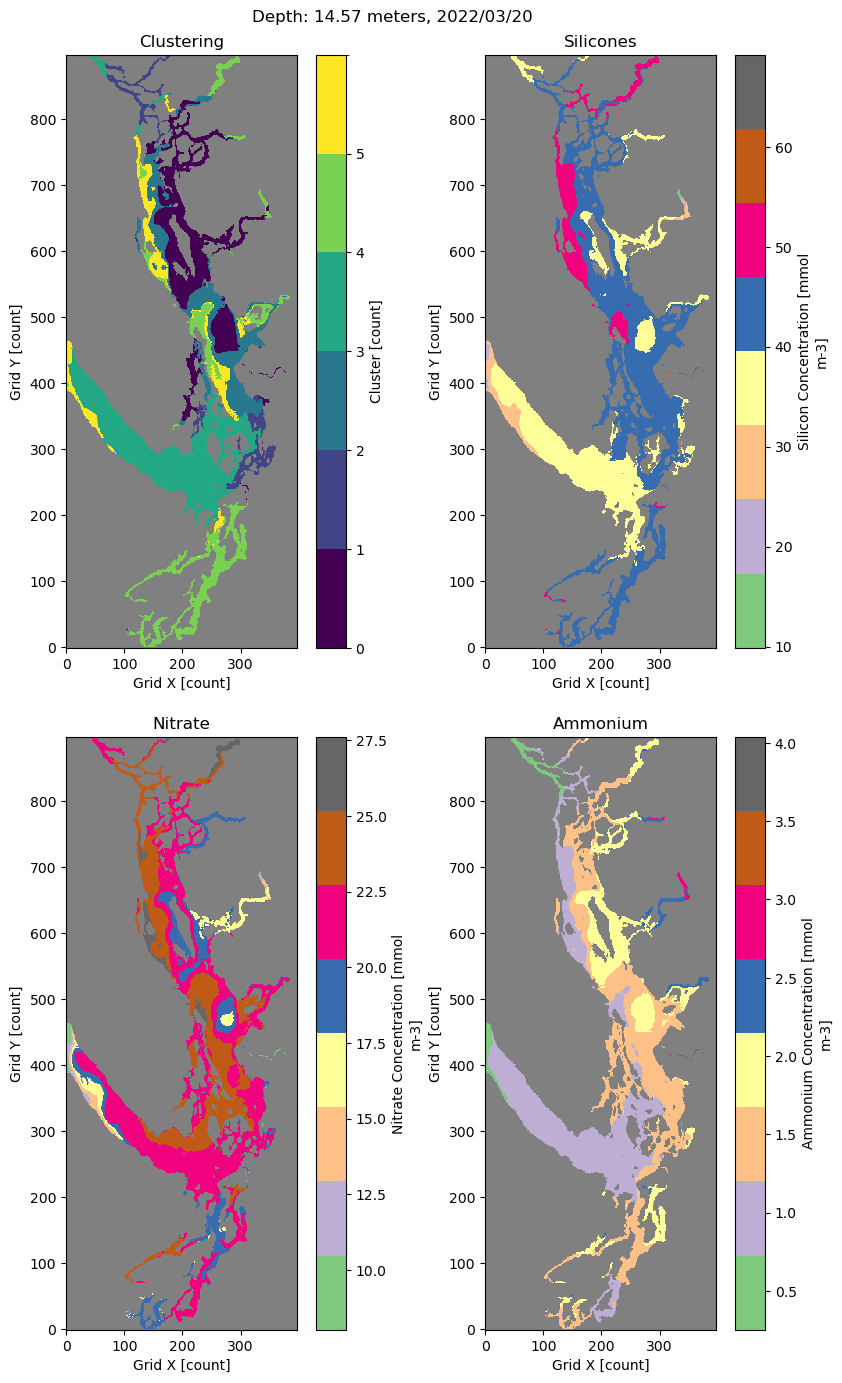

The amount of grid boxes for cluster 0 is 8471 

The minimum temperature for cluster 0 is 8.08 degrees Celsius
The maximum temperature for cluster 0 is 8.48 degrees Celsius
The mean temperature for cluster 0 is 8.19 degrees Celsius 

The minimum salinity for cluster 0 is 28.34 g/kg
The maximum salinity for cluster 0 is 29.82 g/kg
The mean salinity for cluster 0 is 29.17 g/kg 


The amount of grid boxes for cluster 1 is 7892 

The minimum temperature for cluster 1 is 8.15 degrees Celsius
The maximum temperature for cluster 1 is 10.26 degrees Celsius
The mean temperature for cluster 1 is 8.85 degrees Celsius 

The minimum salinity for cluster 1 is 19.41 g/kg
The maximum salinity for cluster 1 is 29.82 g/kg
The mean salinity for cluster 1 is 28.54 g/kg 


The amount of grid boxes for cluster 2 is 4598 

The minimum temperature for cluster 2 is 7.73 degrees Celsius
The maximum temperature for cluster 2 is 8.13 degrees Celsius
The mean temperature for cluster 2 is 7.91 degrees Celsius 

The

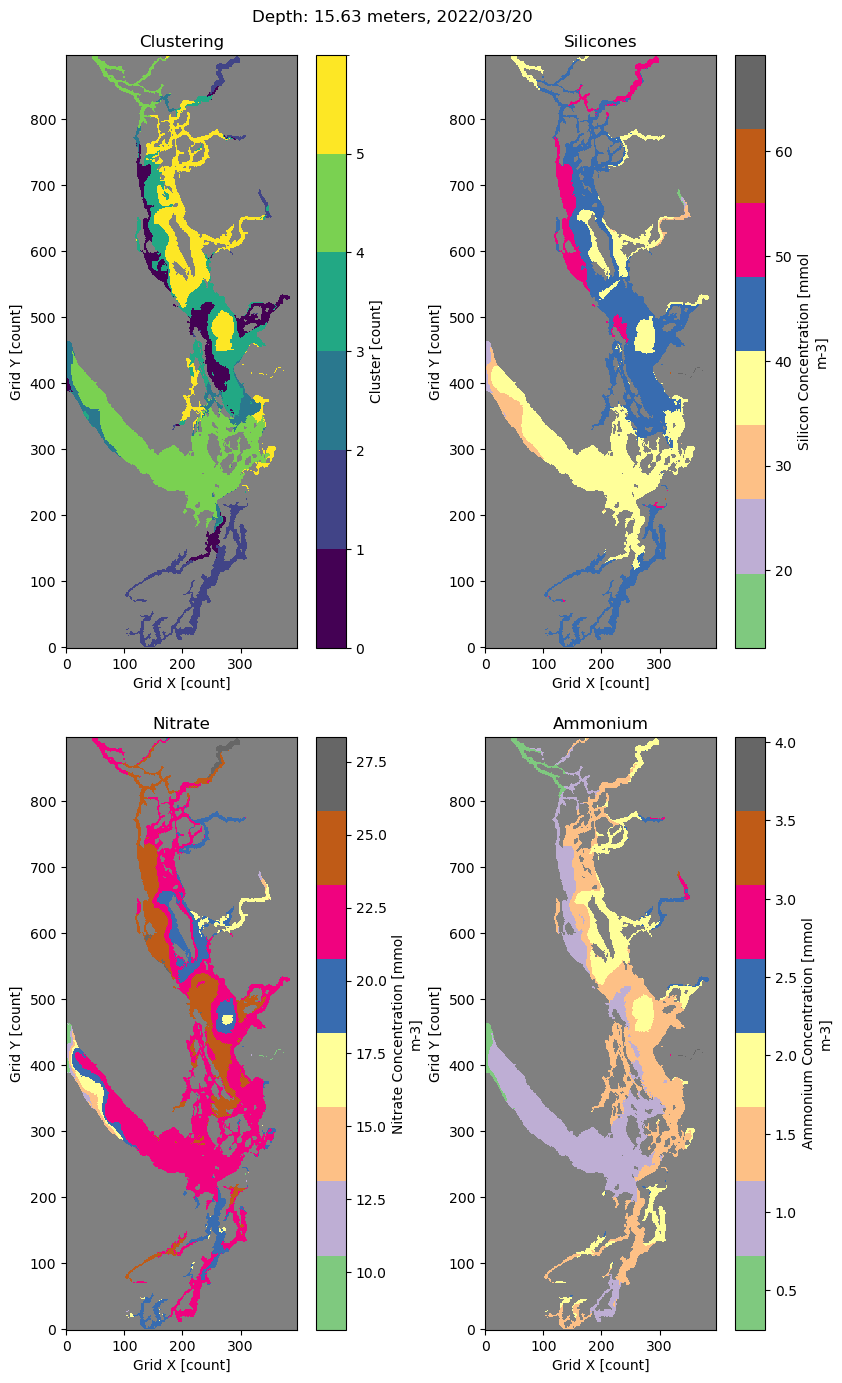

The amount of grid boxes for cluster 0 is 11495 

The minimum temperature for cluster 0 is 8.2 degrees Celsius
The maximum temperature for cluster 0 is 10.41 degrees Celsius
The mean temperature for cluster 0 is 8.68 degrees Celsius 

The minimum salinity for cluster 0 is 21.31 g/kg
The maximum salinity for cluster 0 is 29.82 g/kg
The mean salinity for cluster 0 is 28.82 g/kg 


The amount of grid boxes for cluster 1 is 12016 

The minimum temperature for cluster 1 is 7.91 degrees Celsius
The maximum temperature for cluster 1 is 8.34 degrees Celsius
The mean temperature for cluster 1 is 8.08 degrees Celsius 

The minimum salinity for cluster 1 is 20.22 g/kg
The maximum salinity for cluster 1 is 29.65 g/kg
The mean salinity for cluster 1 is 29.05 g/kg 


The amount of grid boxes for cluster 2 is 4851 

The minimum temperature for cluster 2 is 7.79 degrees Celsius
The maximum temperature for cluster 2 is 8.19 degrees Celsius
The mean temperature for cluster 2 is 7.94 degrees Celsius 

Th

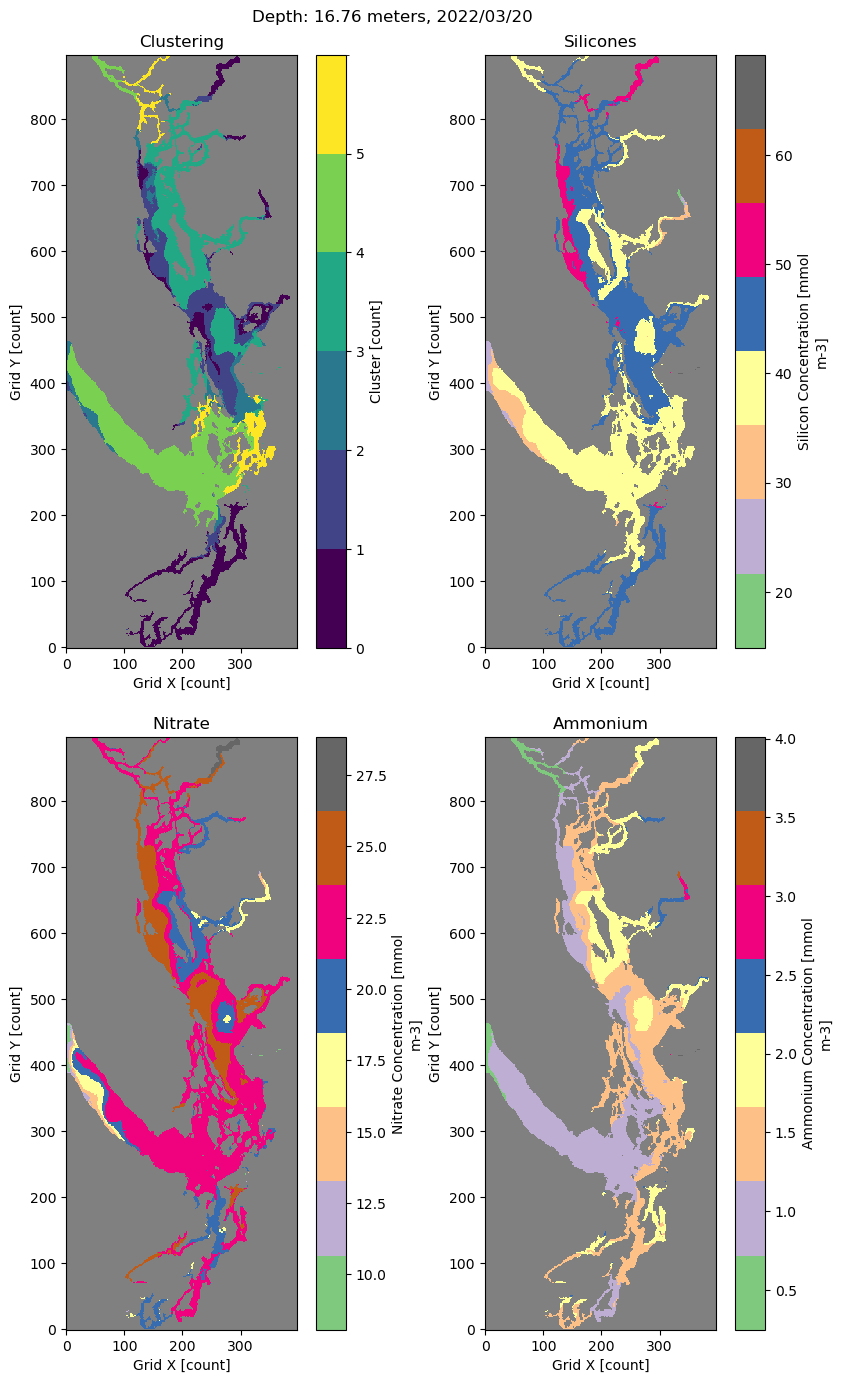

The amount of grid boxes for cluster 0 is 21710 

The minimum temperature for cluster 0 is 6.88 degrees Celsius
The maximum temperature for cluster 0 is 8.1 degrees Celsius
The mean temperature for cluster 0 is 7.67 degrees Celsius 

The minimum salinity for cluster 0 is 29.8 g/kg
The maximum salinity for cluster 0 is 31.38 g/kg
The mean salinity for cluster 0 is 30.48 g/kg 


The amount of grid boxes for cluster 1 is 4996 

The minimum temperature for cluster 1 is 6.16 degrees Celsius
The maximum temperature for cluster 1 is 7.82 degrees Celsius
The mean temperature for cluster 1 is 7.6 degrees Celsius 

The minimum salinity for cluster 1 is 28.98 g/kg
The maximum salinity for cluster 1 is 30.02 g/kg
The mean salinity for cluster 1 is 29.61 g/kg 


The amount of grid boxes for cluster 2 is 5541 

The minimum temperature for cluster 2 is 7.78 degrees Celsius
The maximum temperature for cluster 2 is 8.16 degrees Celsius
The mean temperature for cluster 2 is 7.95 degrees Celsius 

The mi

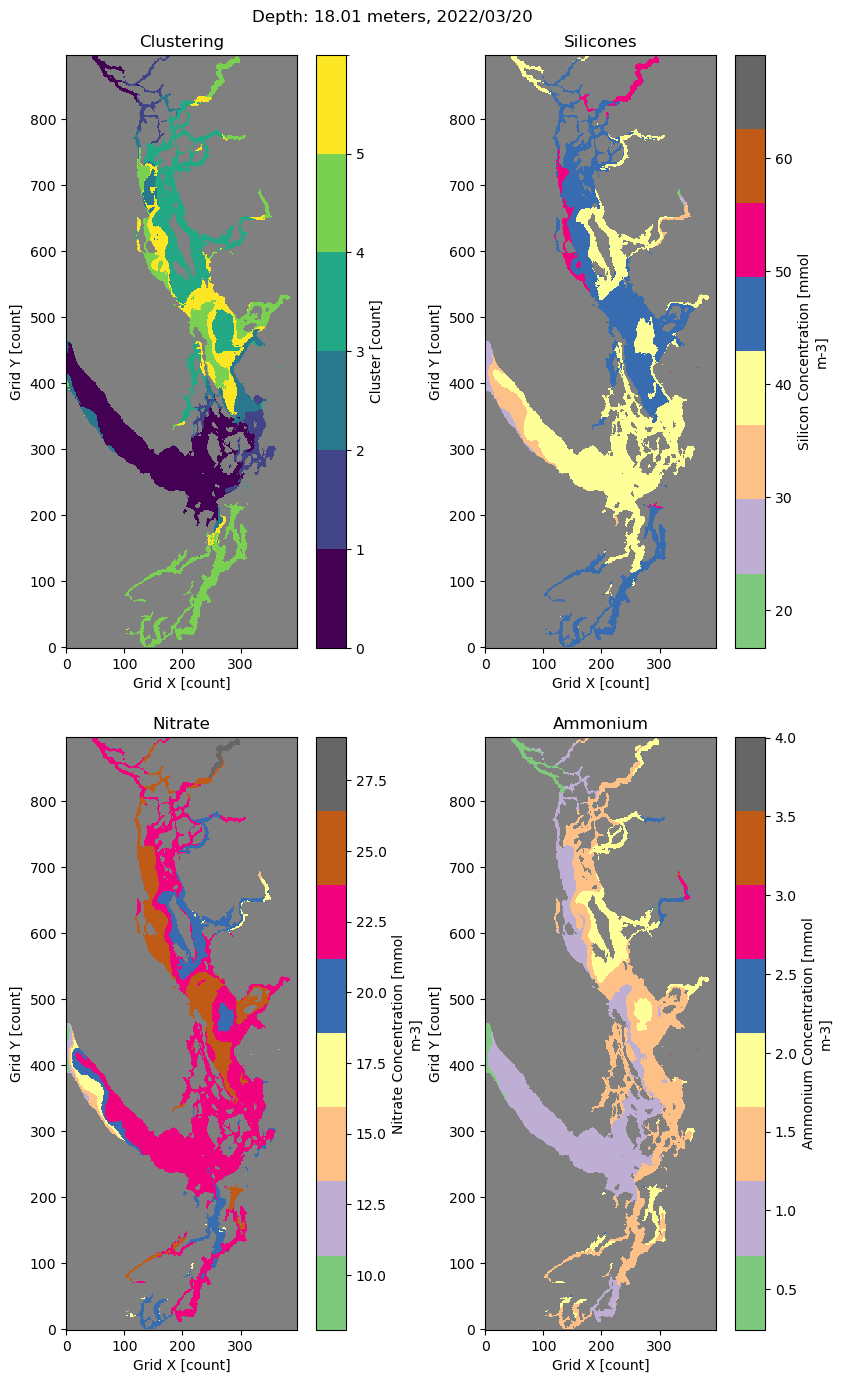

The amount of grid boxes for cluster 0 is 24526 

The minimum temperature for cluster 0 is 6.3 degrees Celsius
The maximum temperature for cluster 0 is 7.98 degrees Celsius
The mean temperature for cluster 0 is 7.65 degrees Celsius 

The minimum salinity for cluster 0 is 29.32 g/kg
The maximum salinity for cluster 0 is 31.4 g/kg
The mean salinity for cluster 0 is 30.4 g/kg 


The amount of grid boxes for cluster 1 is 1266 

The minimum temperature for cluster 1 is 7.86 degrees Celsius
The maximum temperature for cluster 1 is 8.15 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 29.45 g/kg
The maximum salinity for cluster 1 is 30.81 g/kg
The mean salinity for cluster 1 is 30.04 g/kg 


The amount of grid boxes for cluster 2 is 5189 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 8.1 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The min

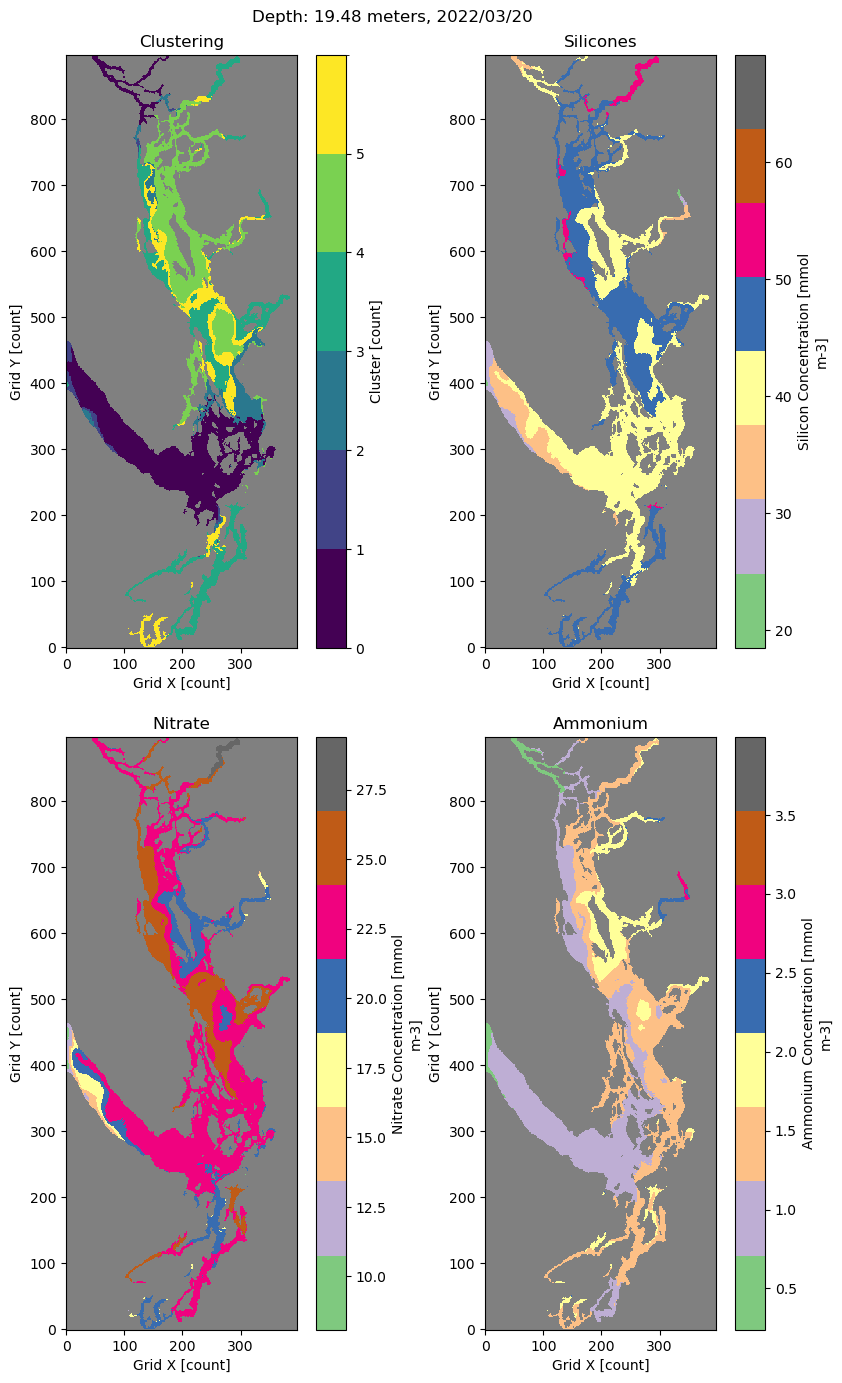

The amount of grid boxes for cluster 0 is 7163 

The minimum temperature for cluster 0 is 8.21 degrees Celsius
The maximum temperature for cluster 0 is 8.55 degrees Celsius
The mean temperature for cluster 0 is 8.31 degrees Celsius 

The minimum salinity for cluster 0 is 28.3 g/kg
The maximum salinity for cluster 0 is 29.84 g/kg
The mean salinity for cluster 0 is 29.32 g/kg 


The amount of grid boxes for cluster 1 is 7867 

The minimum temperature for cluster 1 is 8.32 degrees Celsius
The maximum temperature for cluster 1 is 10.77 degrees Celsius
The mean temperature for cluster 1 is 8.95 degrees Celsius 

The minimum salinity for cluster 1 is 22.78 g/kg
The maximum salinity for cluster 1 is 29.69 g/kg
The mean salinity for cluster 1 is 28.89 g/kg 


The amount of grid boxes for cluster 2 is 3013 

The minimum temperature for cluster 2 is 7.78 degrees Celsius
The maximum temperature for cluster 2 is 8.13 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

The 

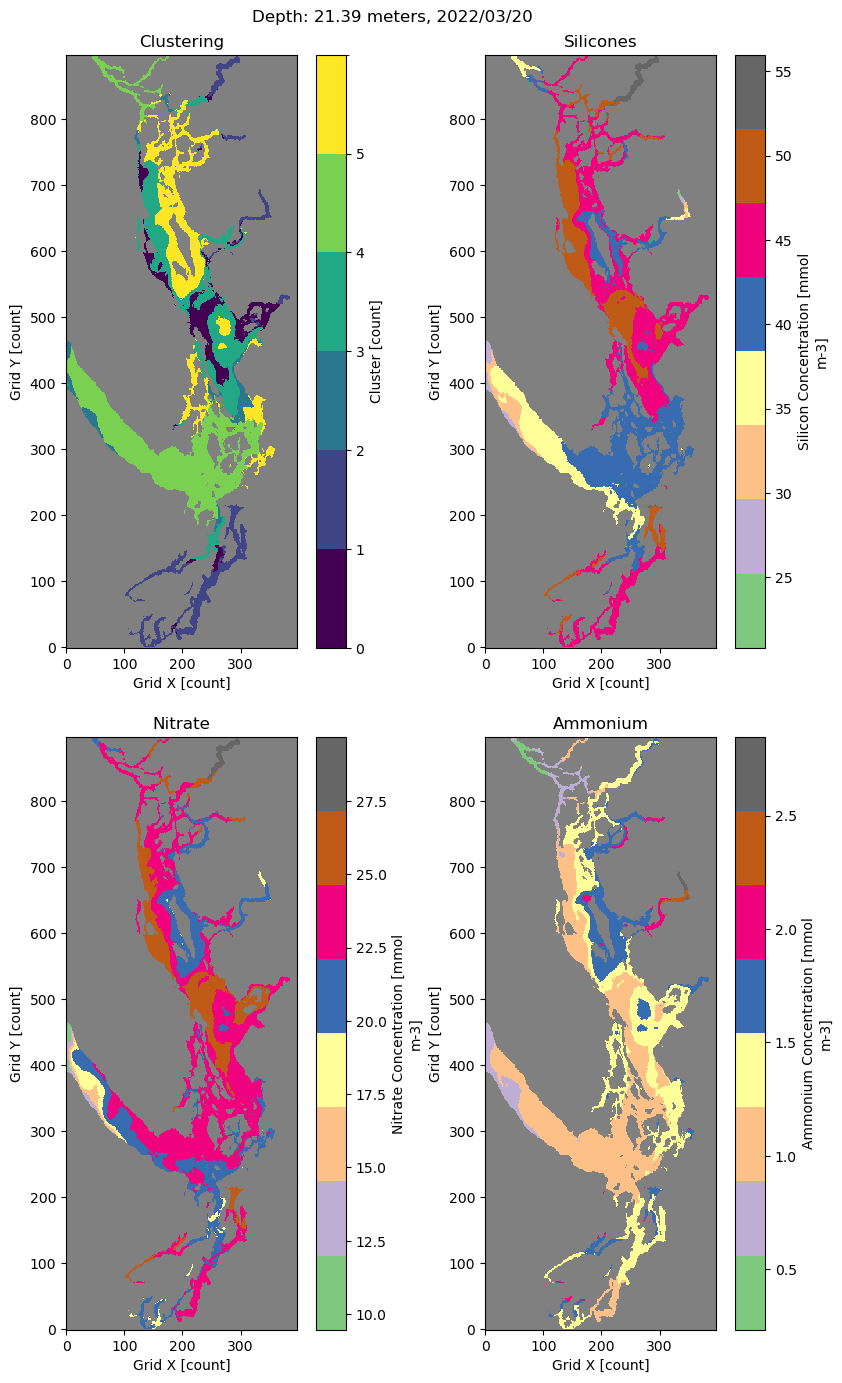

The amount of grid boxes for cluster 0 is 285 

The minimum temperature for cluster 0 is 7.92 degrees Celsius
The maximum temperature for cluster 0 is 8.23 degrees Celsius
The mean temperature for cluster 0 is 8.04 degrees Celsius 

The minimum salinity for cluster 0 is 29.56 g/kg
The maximum salinity for cluster 0 is 31.0 g/kg
The mean salinity for cluster 0 is 30.16 g/kg 


The amount of grid boxes for cluster 1 is 24858 

The minimum temperature for cluster 1 is 6.77 degrees Celsius
The maximum temperature for cluster 1 is 8.03 degrees Celsius
The mean temperature for cluster 1 is 7.65 degrees Celsius 

The minimum salinity for cluster 1 is 29.37 g/kg
The maximum salinity for cluster 1 is 31.45 g/kg
The mean salinity for cluster 1 is 30.46 g/kg 


The amount of grid boxes for cluster 2 is 14074 

The minimum temperature for cluster 2 is 8.23 degrees Celsius
The maximum temperature for cluster 2 is 10.78 degrees Celsius
The mean temperature for cluster 2 is 8.74 degrees Celsius 

The

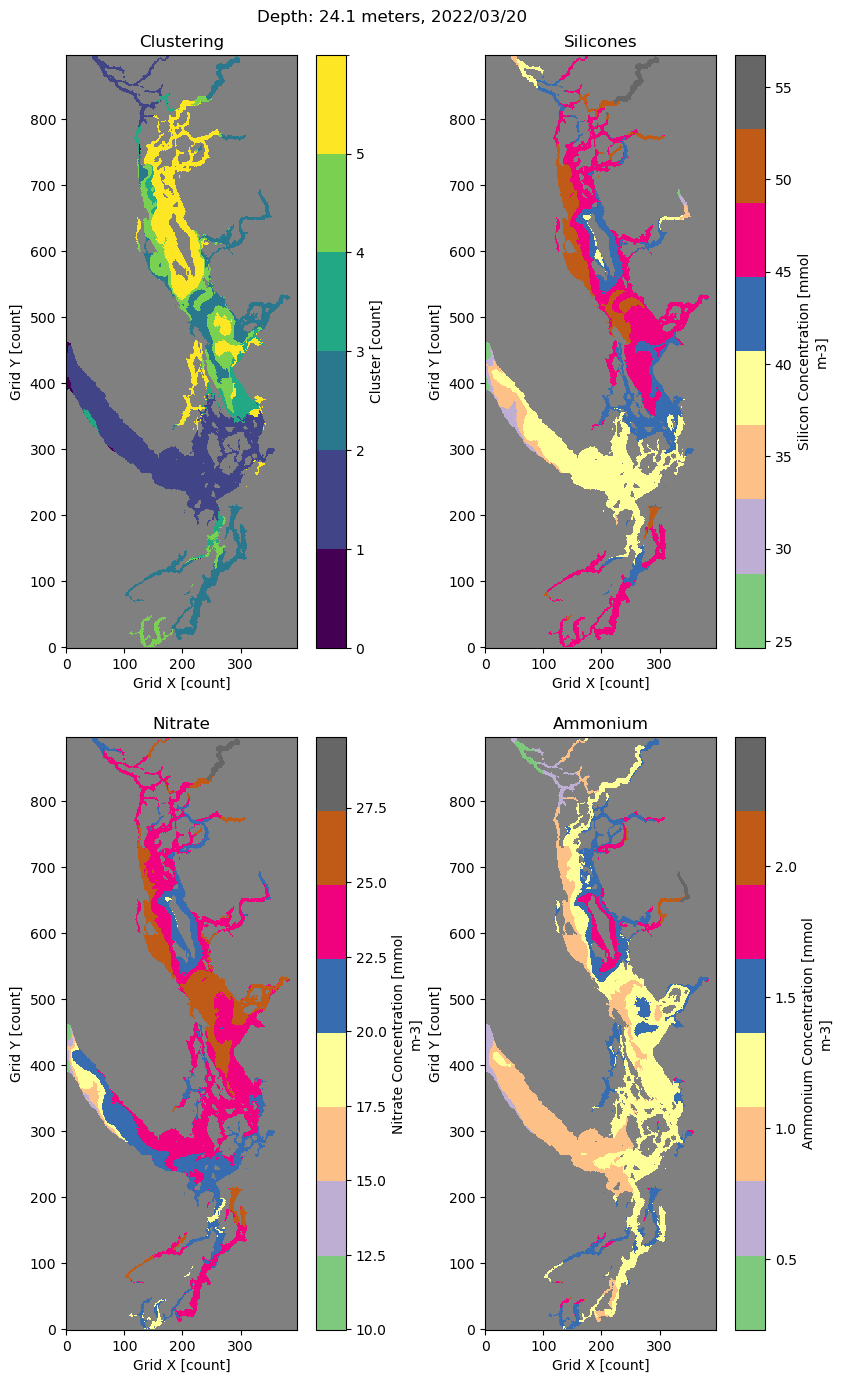

The amount of grid boxes for cluster 0 is 21091 

The minimum temperature for cluster 0 is 6.93 degrees Celsius
The maximum temperature for cluster 0 is 7.99 degrees Celsius
The mean temperature for cluster 0 is 7.63 degrees Celsius 

The minimum salinity for cluster 0 is 29.77 g/kg
The maximum salinity for cluster 0 is 31.5 g/kg
The mean salinity for cluster 0 is 30.65 g/kg 


The amount of grid boxes for cluster 1 is 12276 

The minimum temperature for cluster 1 is 7.31 degrees Celsius
The maximum temperature for cluster 1 is 7.88 degrees Celsius
The mean temperature for cluster 1 is 7.69 degrees Celsius 

The minimum salinity for cluster 1 is 28.42 g/kg
The maximum salinity for cluster 1 is 30.04 g/kg
The mean salinity for cluster 1 is 29.16 g/kg 


The amount of grid boxes for cluster 2 is 765 

The minimum temperature for cluster 2 is 7.84 degrees Celsius
The maximum temperature for cluster 2 is 8.12 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

The 

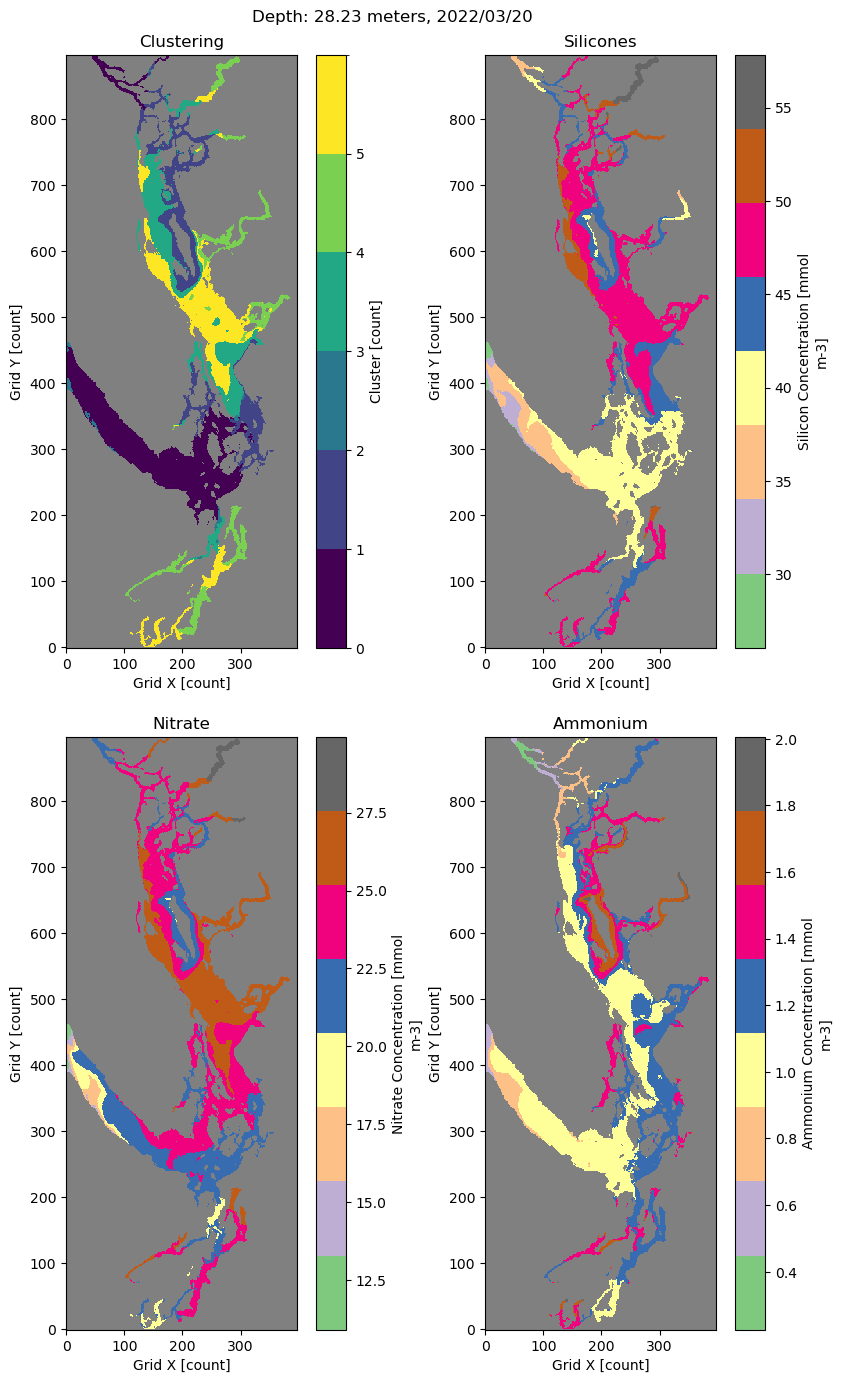

The amount of grid boxes for cluster 0 is 12816 

The minimum temperature for cluster 0 is 7.42 degrees Celsius
The maximum temperature for cluster 0 is 7.96 degrees Celsius
The mean temperature for cluster 0 is 7.78 degrees Celsius 

The minimum salinity for cluster 0 is 28.45 g/kg
The maximum salinity for cluster 0 is 30.21 g/kg
The mean salinity for cluster 0 is 29.27 g/kg 


The amount of grid boxes for cluster 1 is 21092 

The minimum temperature for cluster 1 is 6.99 degrees Celsius
The maximum temperature for cluster 1 is 7.99 degrees Celsius
The mean temperature for cluster 1 is 7.61 degrees Celsius 

The minimum salinity for cluster 1 is 29.57 g/kg
The maximum salinity for cluster 1 is 31.63 g/kg
The mean salinity for cluster 1 is 30.78 g/kg 


The amount of grid boxes for cluster 2 is 11338 

The minimum temperature for cluster 2 is 7.95 degrees Celsius
The maximum temperature for cluster 2 is 8.34 degrees Celsius
The mean temperature for cluster 2 is 8.15 degrees Celsius 

T

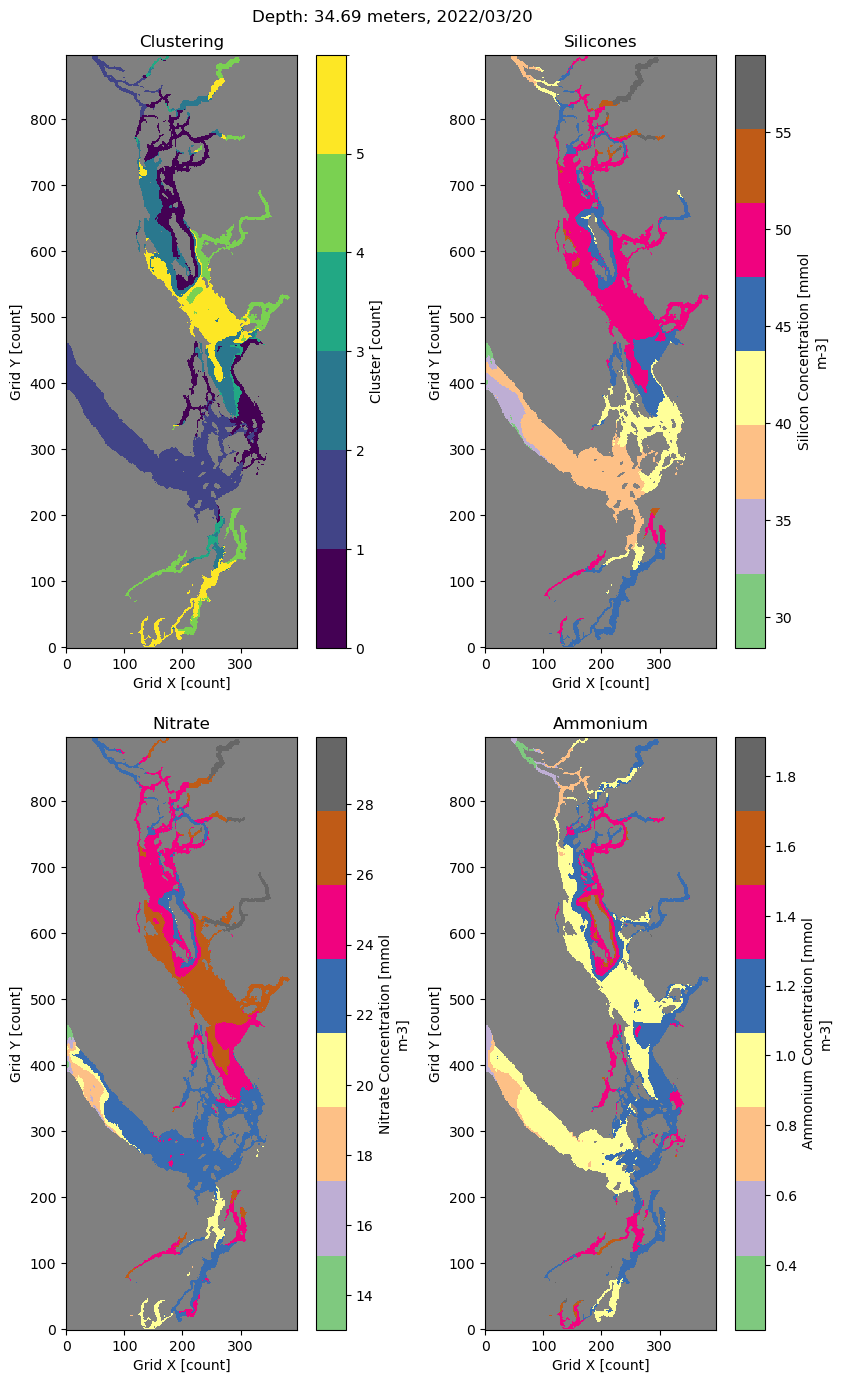

The amount of grid boxes for cluster 0 is 19667 

The minimum temperature for cluster 0 is 7.02 degrees Celsius
The maximum temperature for cluster 0 is 7.97 degrees Celsius
The mean temperature for cluster 0 is 7.57 degrees Celsius 

The minimum salinity for cluster 0 is 29.59 g/kg
The maximum salinity for cluster 0 is 32.03 g/kg
The mean salinity for cluster 0 is 31.03 g/kg 


The amount of grid boxes for cluster 1 is 6814 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 7.92 degrees Celsius
The mean temperature for cluster 1 is 7.75 degrees Celsius 

The minimum salinity for cluster 1 is 28.74 g/kg
The maximum salinity for cluster 1 is 30.43 g/kg
The mean salinity for cluster 1 is 29.69 g/kg 


The amount of grid boxes for cluster 2 is 2150 

The minimum temperature for cluster 2 is 7.92 degrees Celsius
The maximum temperature for cluster 2 is 8.17 degrees Celsius
The mean temperature for cluster 2 is 7.98 degrees Celsius 

The

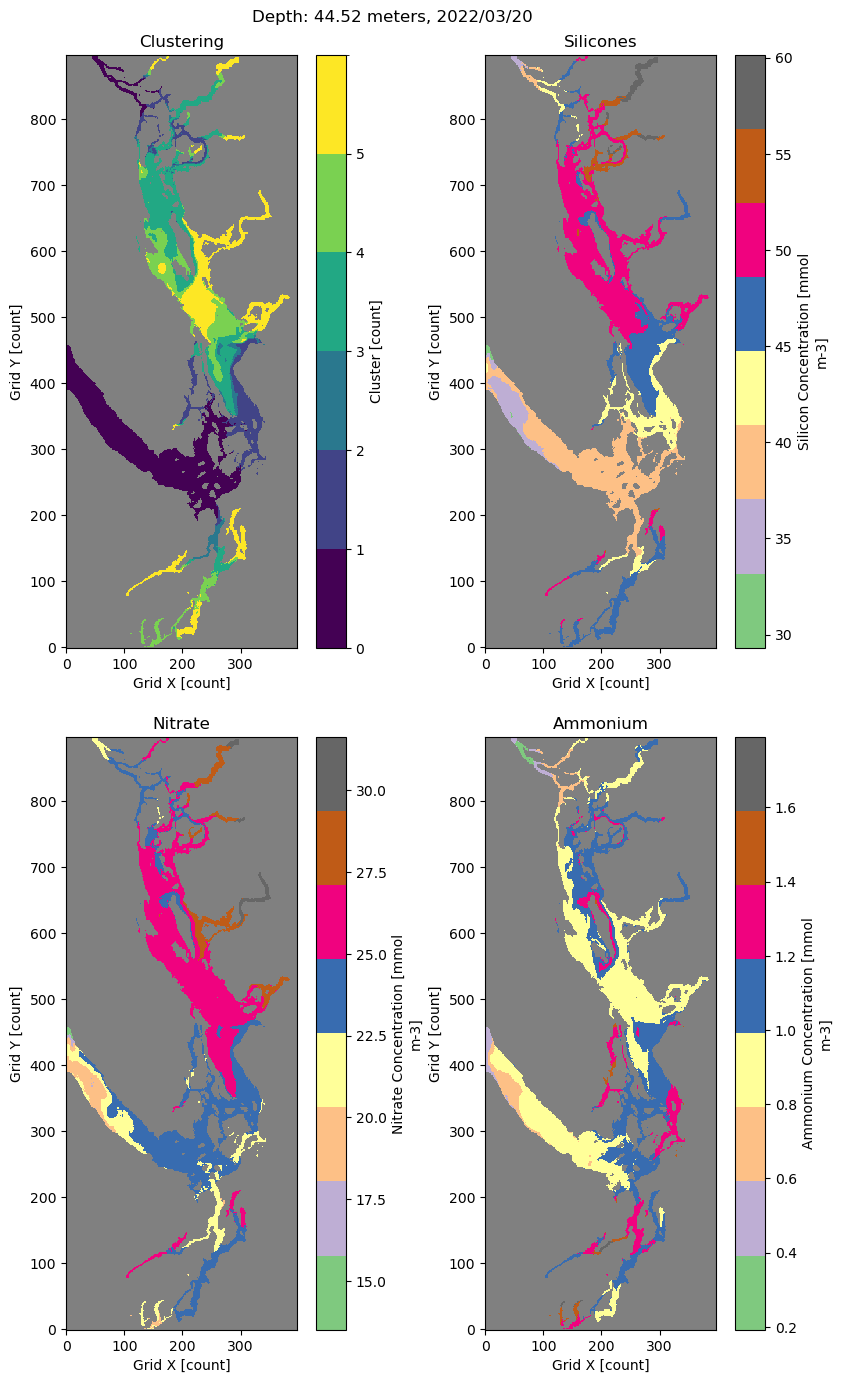

The amount of grid boxes for cluster 0 is 7240 

The minimum temperature for cluster 0 is 8.68 degrees Celsius
The maximum temperature for cluster 0 is 10.5 degrees Celsius
The mean temperature for cluster 0 is 9.13 degrees Celsius 

The minimum salinity for cluster 0 is 29.58 g/kg
The maximum salinity for cluster 0 is 30.43 g/kg
The mean salinity for cluster 0 is 30.0 g/kg 


The amount of grid boxes for cluster 1 is 14135 

The minimum temperature for cluster 1 is 8.37 degrees Celsius
The maximum temperature for cluster 1 is 8.71 degrees Celsius
The mean temperature for cluster 1 is 8.55 degrees Celsius 

The minimum salinity for cluster 1 is 27.4 g/kg
The maximum salinity for cluster 1 is 30.32 g/kg
The mean salinity for cluster 1 is 29.72 g/kg 


The amount of grid boxes for cluster 2 is 175 

The minimum temperature for cluster 2 is 7.95 degrees Celsius
The maximum temperature for cluster 2 is 8.18 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The mi

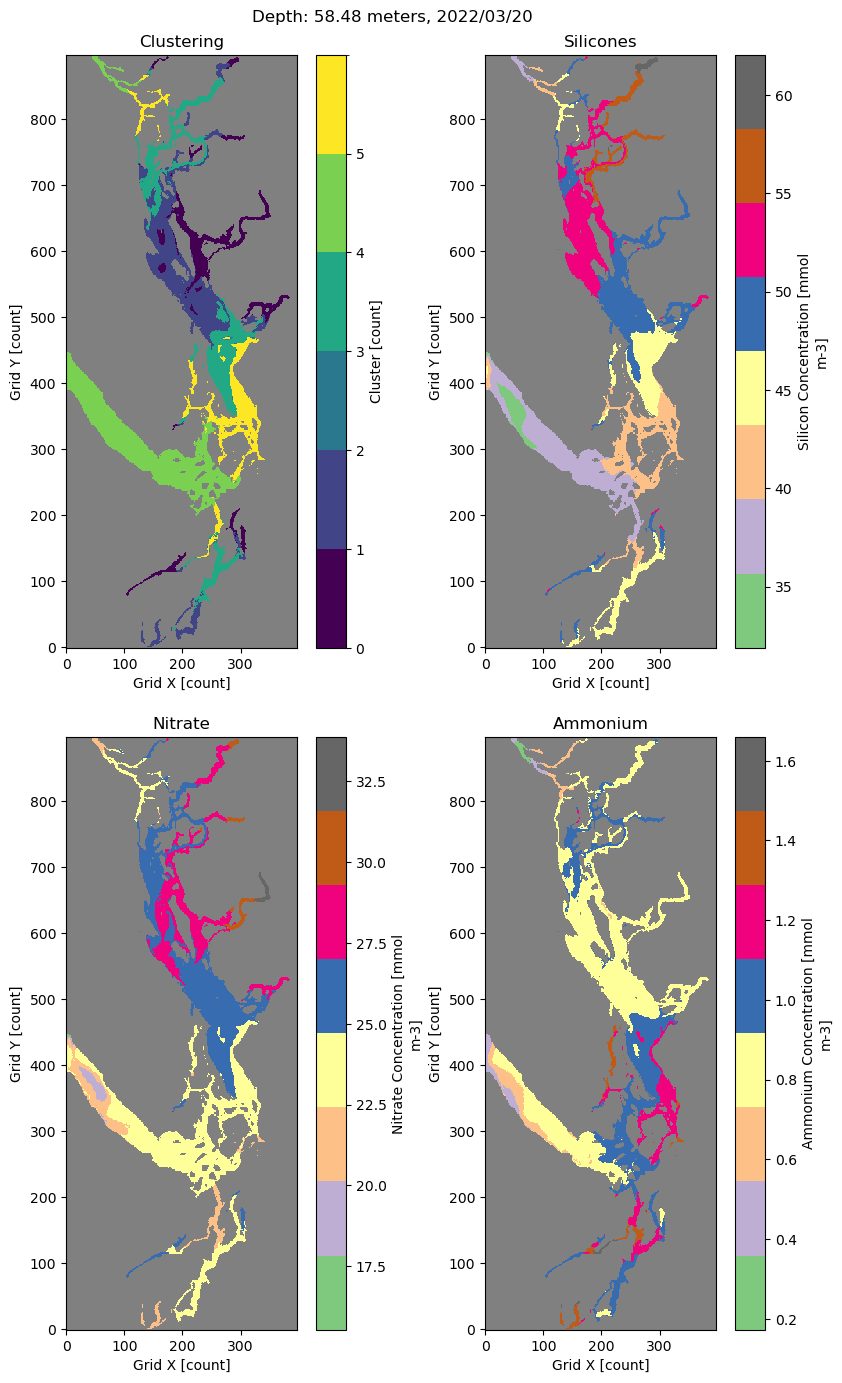

The amount of grid boxes for cluster 0 is 12631 

The minimum temperature for cluster 0 is 8.67 degrees Celsius
The maximum temperature for cluster 0 is 10.58 degrees Celsius
The mean temperature for cluster 0 is 8.96 degrees Celsius 

The minimum salinity for cluster 0 is 29.65 g/kg
The maximum salinity for cluster 0 is 30.48 g/kg
The mean salinity for cluster 0 is 30.04 g/kg 


The amount of grid boxes for cluster 1 is 7847 

The minimum temperature for cluster 1 is 8.4 degrees Celsius
The maximum temperature for cluster 1 is 8.69 degrees Celsius
The mean temperature for cluster 1 is 8.55 degrees Celsius 

The minimum salinity for cluster 1 is 27.46 g/kg
The maximum salinity for cluster 1 is 30.34 g/kg
The mean salinity for cluster 1 is 29.83 g/kg 


The amount of grid boxes for cluster 2 is 6910 

The minimum temperature for cluster 2 is 7.95 degrees Celsius
The maximum temperature for cluster 2 is 8.45 degrees Celsius
The mean temperature for cluster 2 is 8.25 degrees Celsius 

The

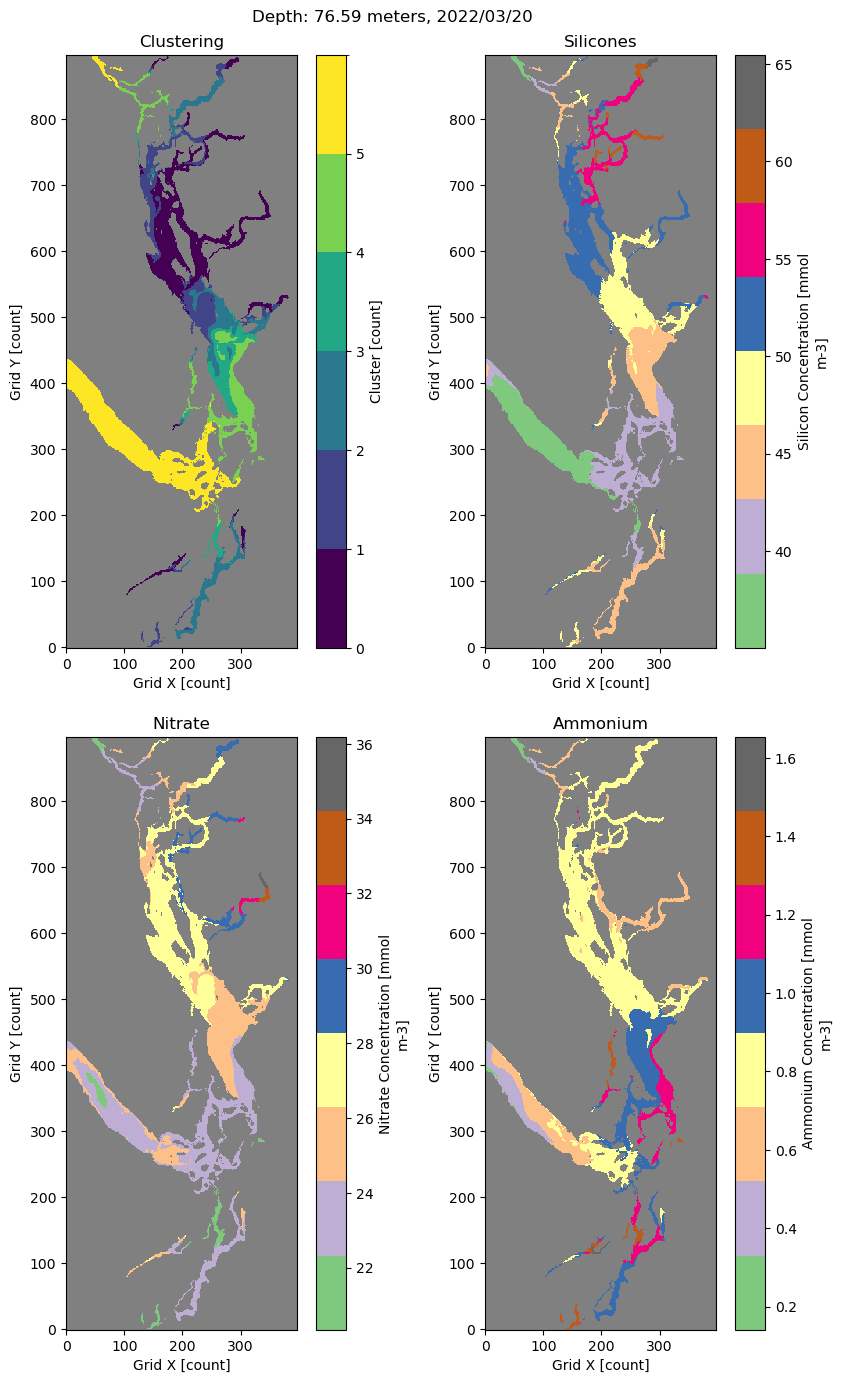

The amount of grid boxes for cluster 0 is 5201 

The minimum temperature for cluster 0 is 8.42 degrees Celsius
The maximum temperature for cluster 0 is 8.75 degrees Celsius
The mean temperature for cluster 0 is 8.61 degrees Celsius 

The minimum salinity for cluster 0 is 27.48 g/kg
The maximum salinity for cluster 0 is 30.39 g/kg
The mean salinity for cluster 0 is 30.01 g/kg 


The amount of grid boxes for cluster 1 is 13100 

The minimum temperature for cluster 1 is 8.75 degrees Celsius
The maximum temperature for cluster 1 is 10.69 degrees Celsius
The mean temperature for cluster 1 is 9.01 degrees Celsius 

The minimum salinity for cluster 1 is 29.74 g/kg
The maximum salinity for cluster 1 is 30.55 g/kg
The mean salinity for cluster 1 is 30.19 g/kg 


The amount of grid boxes for cluster 2 is 4555 

The minimum temperature for cluster 2 is 7.78 degrees Celsius
The maximum temperature for cluster 2 is 8.09 degrees Celsius
The mean temperature for cluster 2 is 7.95 degrees Celsius 

Th

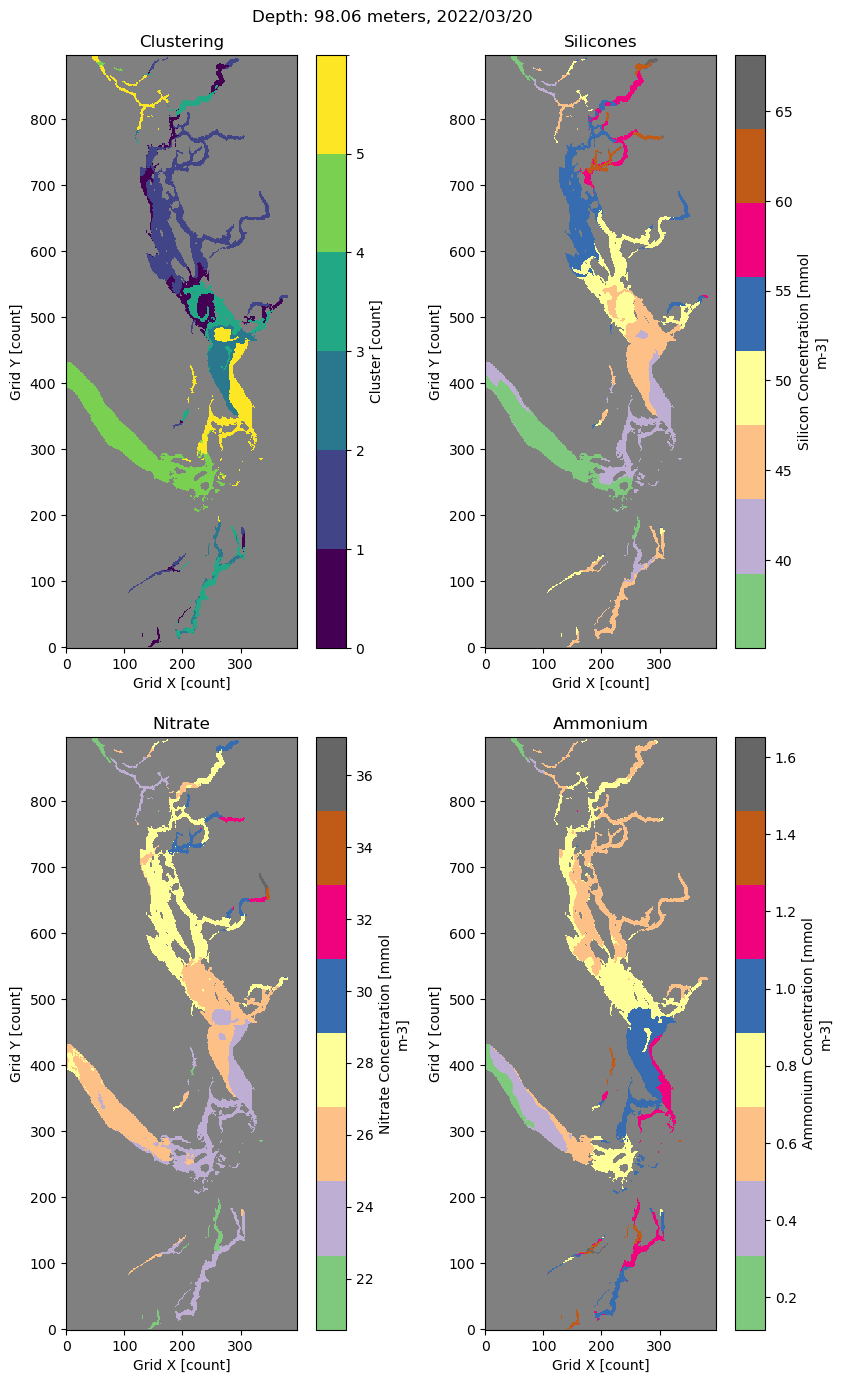

The amount of grid boxes for cluster 0 is 3709 

The minimum temperature for cluster 0 is 8.46 degrees Celsius
The maximum temperature for cluster 0 is 8.81 degrees Celsius
The mean temperature for cluster 0 is 8.65 degrees Celsius 

The minimum salinity for cluster 0 is 28.03 g/kg
The maximum salinity for cluster 0 is 30.5 g/kg
The mean salinity for cluster 0 is 30.2 g/kg 


The amount of grid boxes for cluster 1 is 12934 

The minimum temperature for cluster 1 is 8.8 degrees Celsius
The maximum temperature for cluster 1 is 10.76 degrees Celsius
The mean temperature for cluster 1 is 9.1 degrees Celsius 

The minimum salinity for cluster 1 is 29.82 g/kg
The maximum salinity for cluster 1 is 30.6 g/kg
The mean salinity for cluster 1 is 30.37 g/kg 


The amount of grid boxes for cluster 2 is 6279 

The minimum temperature for cluster 2 is 7.68 degrees Celsius
The maximum temperature for cluster 2 is 8.18 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The min

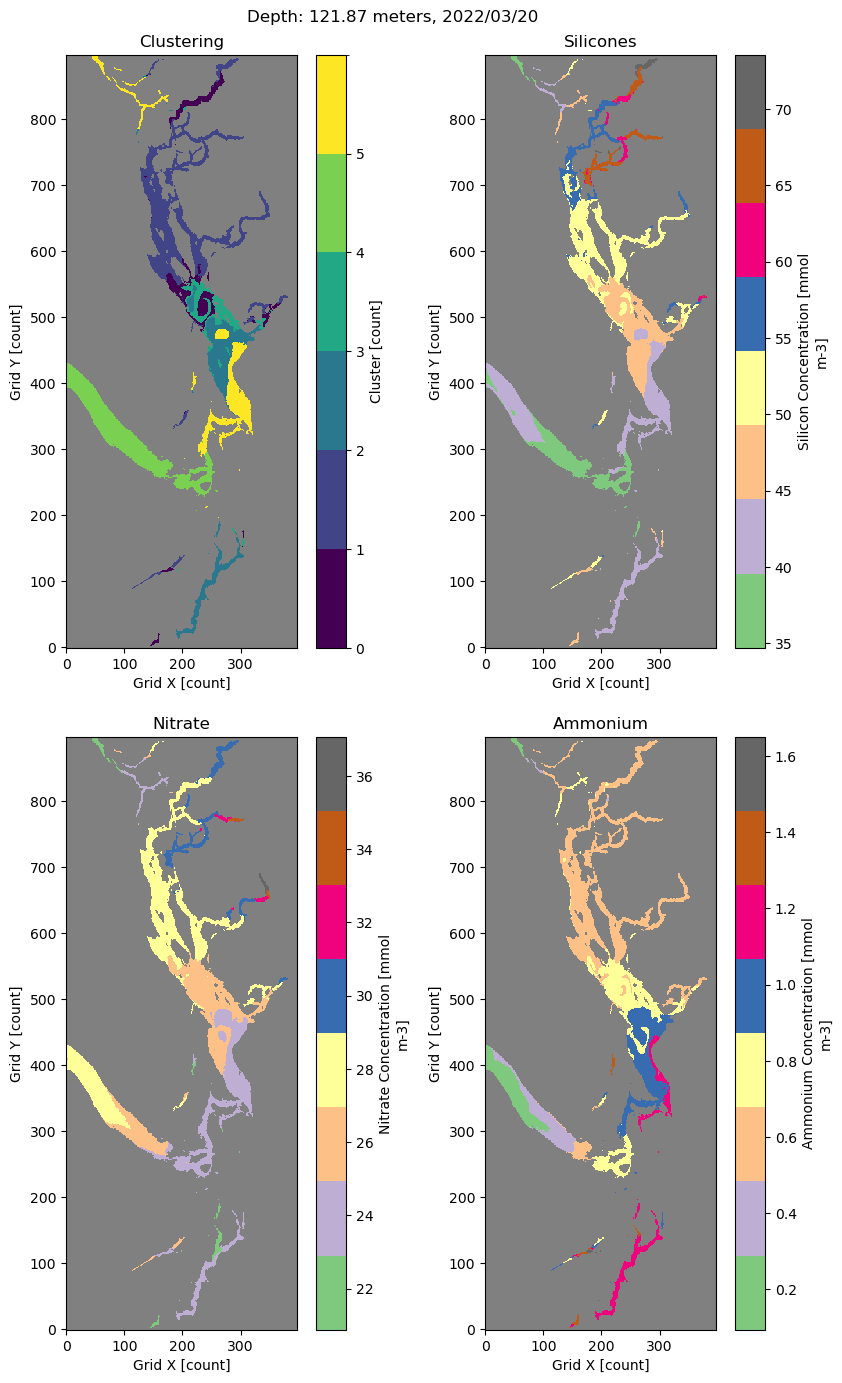

The amount of grid boxes for cluster 0 is 11636 

The minimum temperature for cluster 0 is 8.96 degrees Celsius
The maximum temperature for cluster 0 is 10.81 degrees Celsius
The mean temperature for cluster 0 is 9.19 degrees Celsius 

The minimum salinity for cluster 0 is 29.86 g/kg
The maximum salinity for cluster 0 is 30.8 g/kg
The mean salinity for cluster 0 is 30.53 g/kg 


The amount of grid boxes for cluster 1 is 3148 

The minimum temperature for cluster 1 is 8.65 degrees Celsius
The maximum temperature for cluster 1 is 8.96 degrees Celsius
The mean temperature for cluster 1 is 8.83 degrees Celsius 

The minimum salinity for cluster 1 is 29.8 g/kg
The maximum salinity for cluster 1 is 30.67 g/kg
The mean salinity for cluster 1 is 30.5 g/kg 


The amount of grid boxes for cluster 2 is 3612 

The minimum temperature for cluster 2 is 8.23 degrees Celsius
The maximum temperature for cluster 2 is 8.66 degrees Celsius
The mean temperature for cluster 2 is 8.44 degrees Celsius 

The m

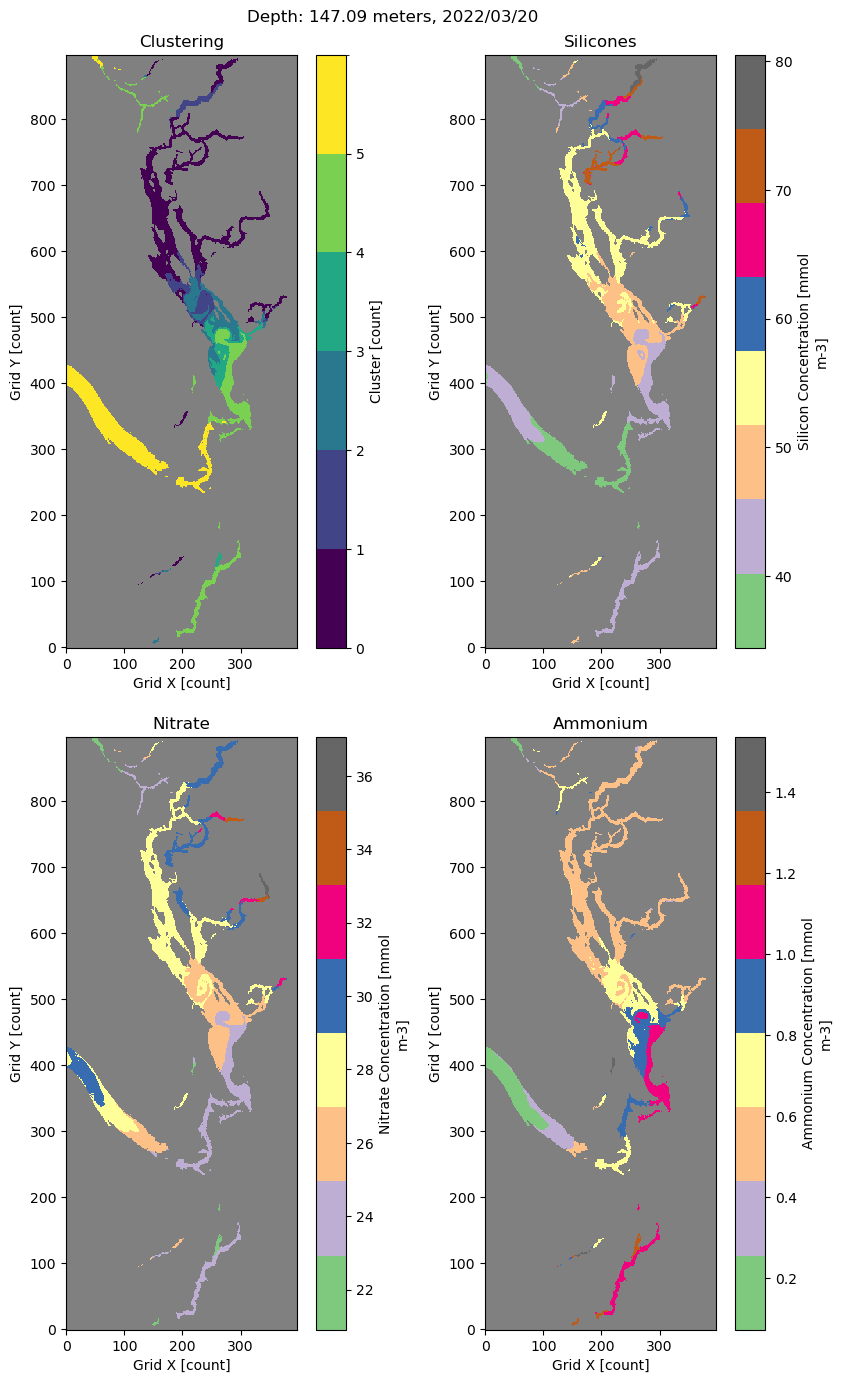

The amount of grid boxes for cluster 0 is 4871 

The minimum temperature for cluster 0 is 6.85 degrees Celsius
The maximum temperature for cluster 0 is 7.45 degrees Celsius
The mean temperature for cluster 0 is 7.09 degrees Celsius 

The minimum salinity for cluster 0 is 31.46 g/kg
The maximum salinity for cluster 0 is 33.76 g/kg
The mean salinity for cluster 0 is 33.36 g/kg 


The amount of grid boxes for cluster 1 is 5032 

The minimum temperature for cluster 1 is 7.32 degrees Celsius
The maximum temperature for cluster 1 is 8.03 degrees Celsius
The mean temperature for cluster 1 is 7.7 degrees Celsius 

The minimum salinity for cluster 1 is 28.9 g/kg
The maximum salinity for cluster 1 is 31.49 g/kg
The mean salinity for cluster 1 is 30.55 g/kg 


The amount of grid boxes for cluster 2 is 1142 

The minimum temperature for cluster 2 is 8.03 degrees Celsius
The maximum temperature for cluster 2 is 8.41 degrees Celsius
The mean temperature for cluster 2 is 8.19 degrees Celsius 

The mi

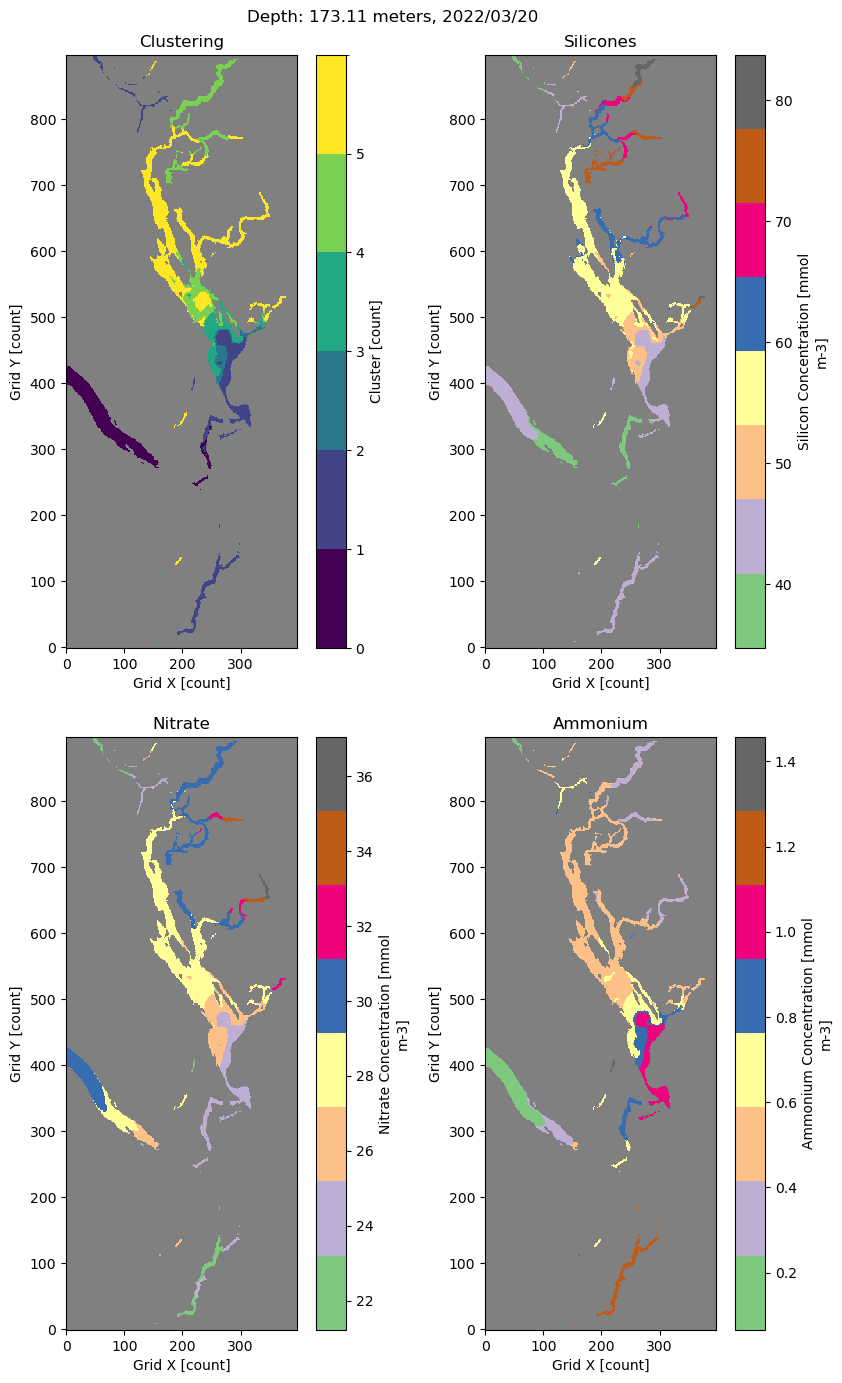

The amount of grid boxes for cluster 0 is 2884 

The minimum temperature for cluster 0 is 6.74 degrees Celsius
The maximum temperature for cluster 0 is 7.47 degrees Celsius
The mean temperature for cluster 0 is 7.03 degrees Celsius 

The minimum salinity for cluster 0 is 31.03 g/kg
The maximum salinity for cluster 0 is 33.83 g/kg
The mean salinity for cluster 0 is 33.2 g/kg 


The amount of grid boxes for cluster 1 is 2977 

The minimum temperature for cluster 1 is 7.32 degrees Celsius
The maximum temperature for cluster 1 is 8.11 degrees Celsius
The mean temperature for cluster 1 is 7.75 degrees Celsius 

The minimum salinity for cluster 1 is 28.91 g/kg
The maximum salinity for cluster 1 is 31.03 g/kg
The mean salinity for cluster 1 is 30.52 g/kg 


The amount of grid boxes for cluster 2 is 901 

The minimum temperature for cluster 2 is 8.11 degrees Celsius
The maximum temperature for cluster 2 is 8.55 degrees Celsius
The mean temperature for cluster 2 is 8.31 degrees Celsius 

The mi

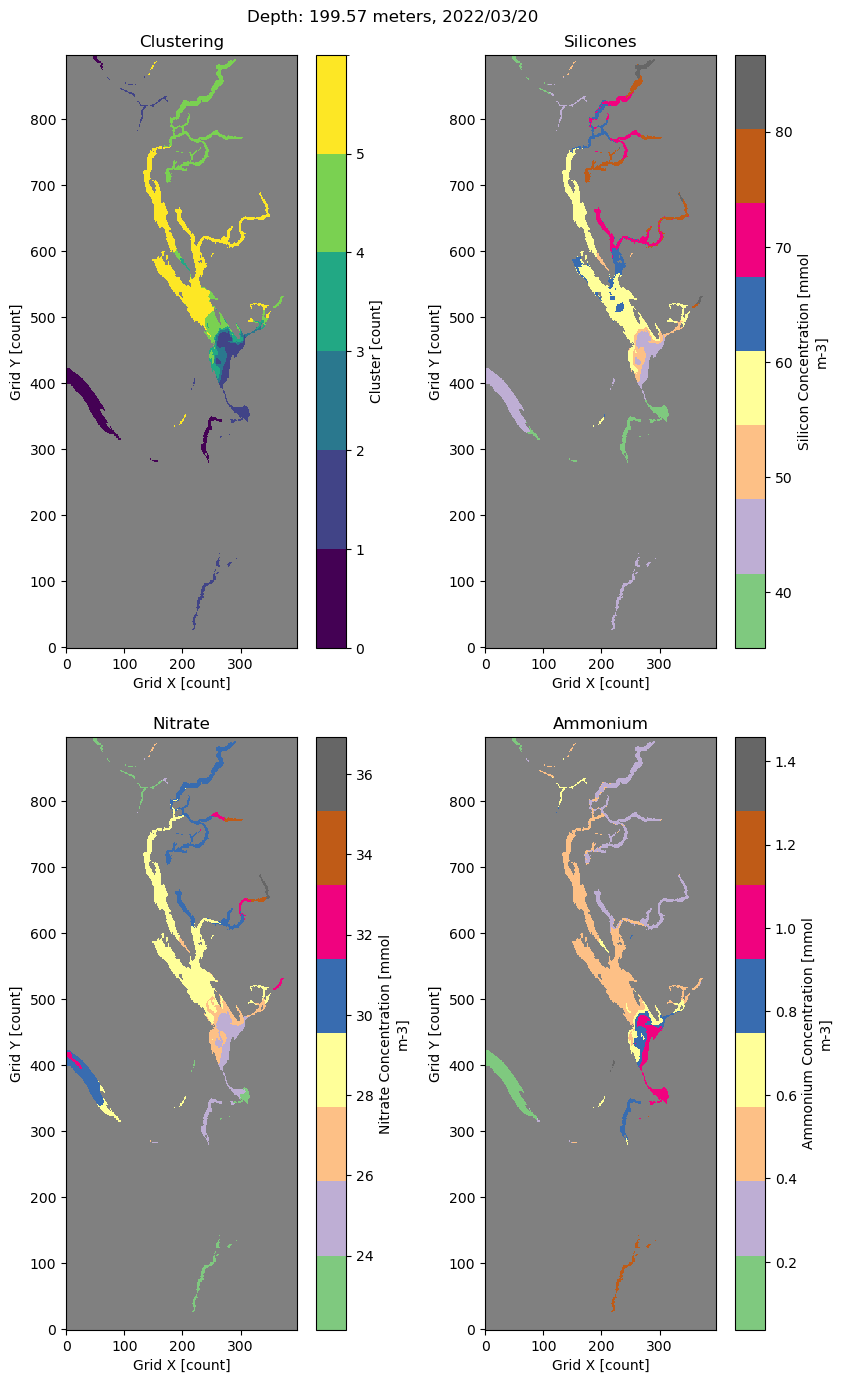

The amount of grid boxes for cluster 0 is 1130 

The minimum temperature for cluster 0 is 9.1 degrees Celsius
The maximum temperature for cluster 0 is 9.24 degrees Celsius
The mean temperature for cluster 0 is 9.18 degrees Celsius 

The minimum salinity for cluster 0 is 30.39 g/kg
The maximum salinity for cluster 0 is 30.98 g/kg
The mean salinity for cluster 0 is 30.81 g/kg 


The amount of grid boxes for cluster 1 is 7541 

The minimum temperature for cluster 1 is 9.24 degrees Celsius
The maximum temperature for cluster 1 is 9.96 degrees Celsius
The mean temperature for cluster 1 is 9.35 degrees Celsius 

The minimum salinity for cluster 1 is 30.07 g/kg
The maximum salinity for cluster 1 is 31.06 g/kg
The mean salinity for cluster 1 is 30.92 g/kg 


The amount of grid boxes for cluster 2 is 632 

The minimum temperature for cluster 2 is 8.46 degrees Celsius
The maximum temperature for cluster 2 is 8.83 degrees Celsius
The mean temperature for cluster 2 is 8.65 degrees Celsius 

The mi

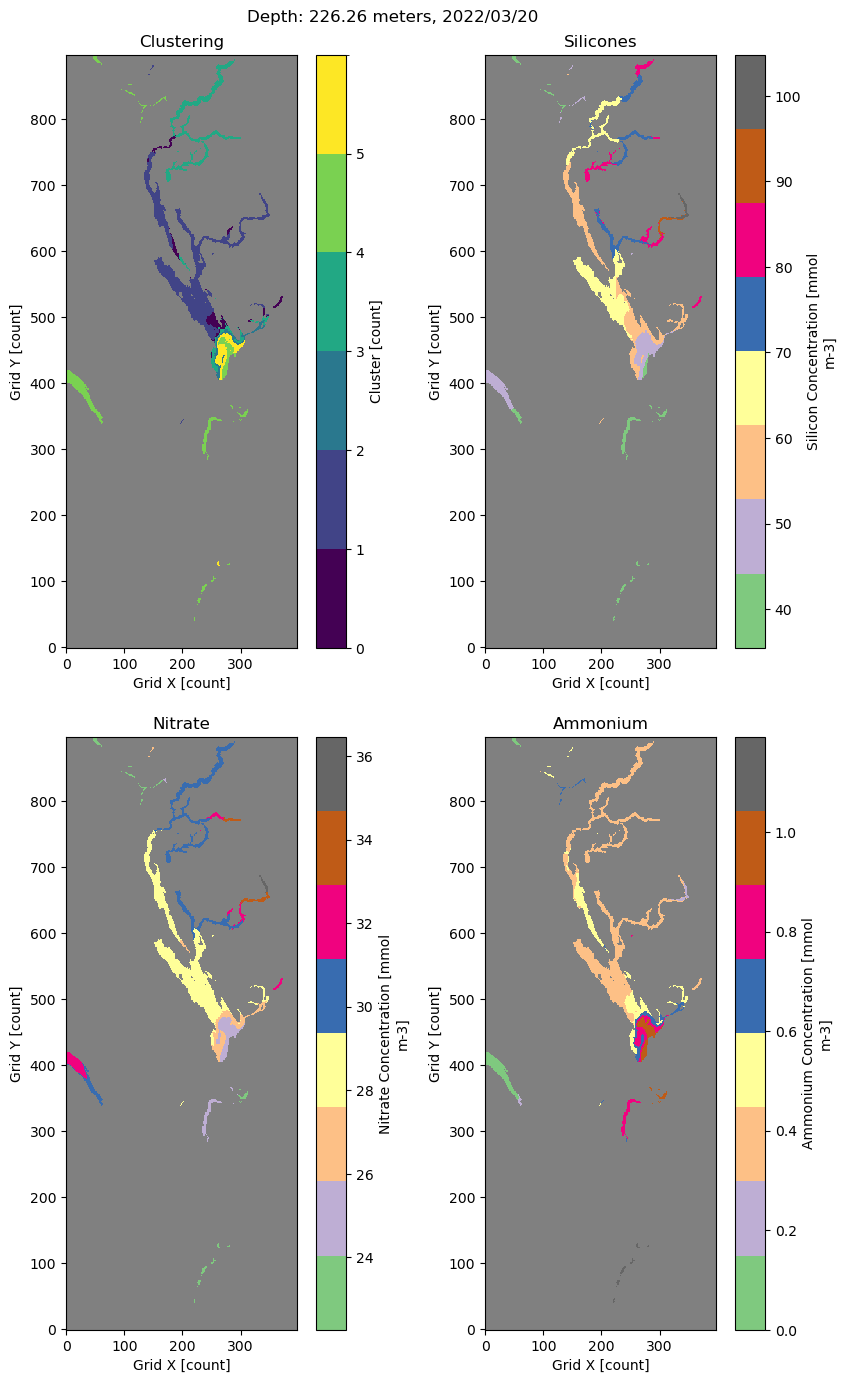

The amount of grid boxes for cluster 0 is 5986 

The minimum temperature for cluster 0 is 9.29 degrees Celsius
The maximum temperature for cluster 0 is 9.73 degrees Celsius
The mean temperature for cluster 0 is 9.38 degrees Celsius 

The minimum salinity for cluster 0 is 30.63 g/kg
The maximum salinity for cluster 0 is 31.1 g/kg
The mean salinity for cluster 0 is 30.99 g/kg 


The amount of grid boxes for cluster 1 is 1241 

The minimum temperature for cluster 1 is 9.18 degrees Celsius
The maximum temperature for cluster 1 is 9.3 degrees Celsius
The mean temperature for cluster 1 is 9.26 degrees Celsius 

The minimum salinity for cluster 1 is 30.67 g/kg
The maximum salinity for cluster 1 is 31.06 g/kg
The mean salinity for cluster 1 is 30.93 g/kg 


The amount of grid boxes for cluster 2 is 2849 

The minimum temperature for cluster 2 is 8.97 degrees Celsius
The maximum temperature for cluster 2 is 9.18 degrees Celsius
The mean temperature for cluster 2 is 9.03 degrees Celsius 

The mi

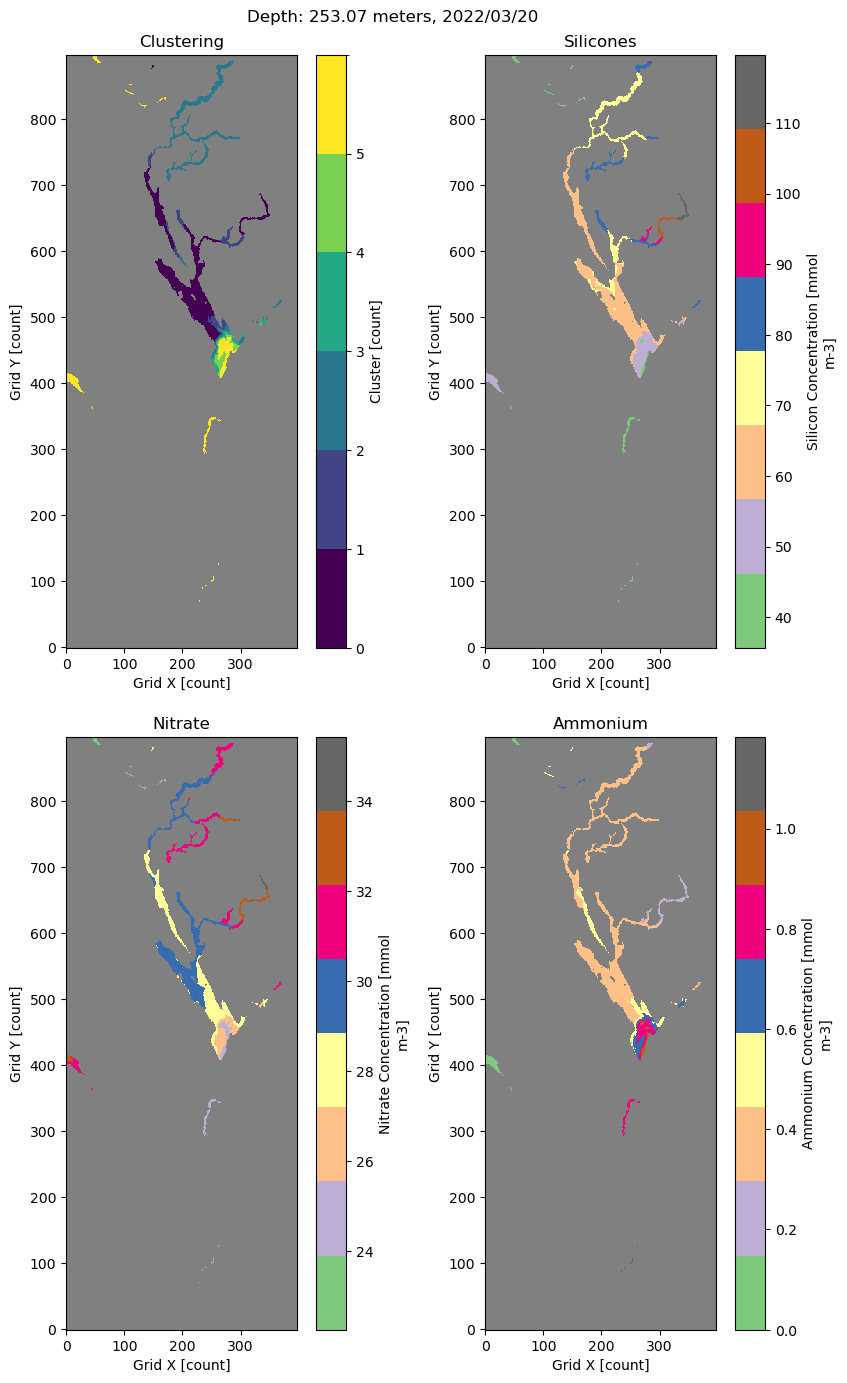

The amount of grid boxes for cluster 0 is 1098 

The minimum temperature for cluster 0 is 6.49 degrees Celsius
The maximum temperature for cluster 0 is 8.59 degrees Celsius
The mean temperature for cluster 0 is 8.06 degrees Celsius 

The minimum salinity for cluster 0 is 29.79 g/kg
The maximum salinity for cluster 0 is 33.95 g/kg
The mean salinity for cluster 0 is 31.11 g/kg 


The amount of grid boxes for cluster 1 is 331 

The minimum temperature for cluster 1 is 8.59 degrees Celsius
The maximum temperature for cluster 1 is 8.84 degrees Celsius
The mean temperature for cluster 1 is 8.71 degrees Celsius 

The minimum salinity for cluster 1 is 30.59 g/kg
The maximum salinity for cluster 1 is 30.97 g/kg
The mean salinity for cluster 1 is 30.91 g/kg 


The amount of grid boxes for cluster 2 is 2398 

The minimum temperature for cluster 2 is 8.83 degrees Celsius
The maximum temperature for cluster 2 is 9.1 degrees Celsius
The mean temperature for cluster 2 is 9.01 degrees Celsius 

The mi

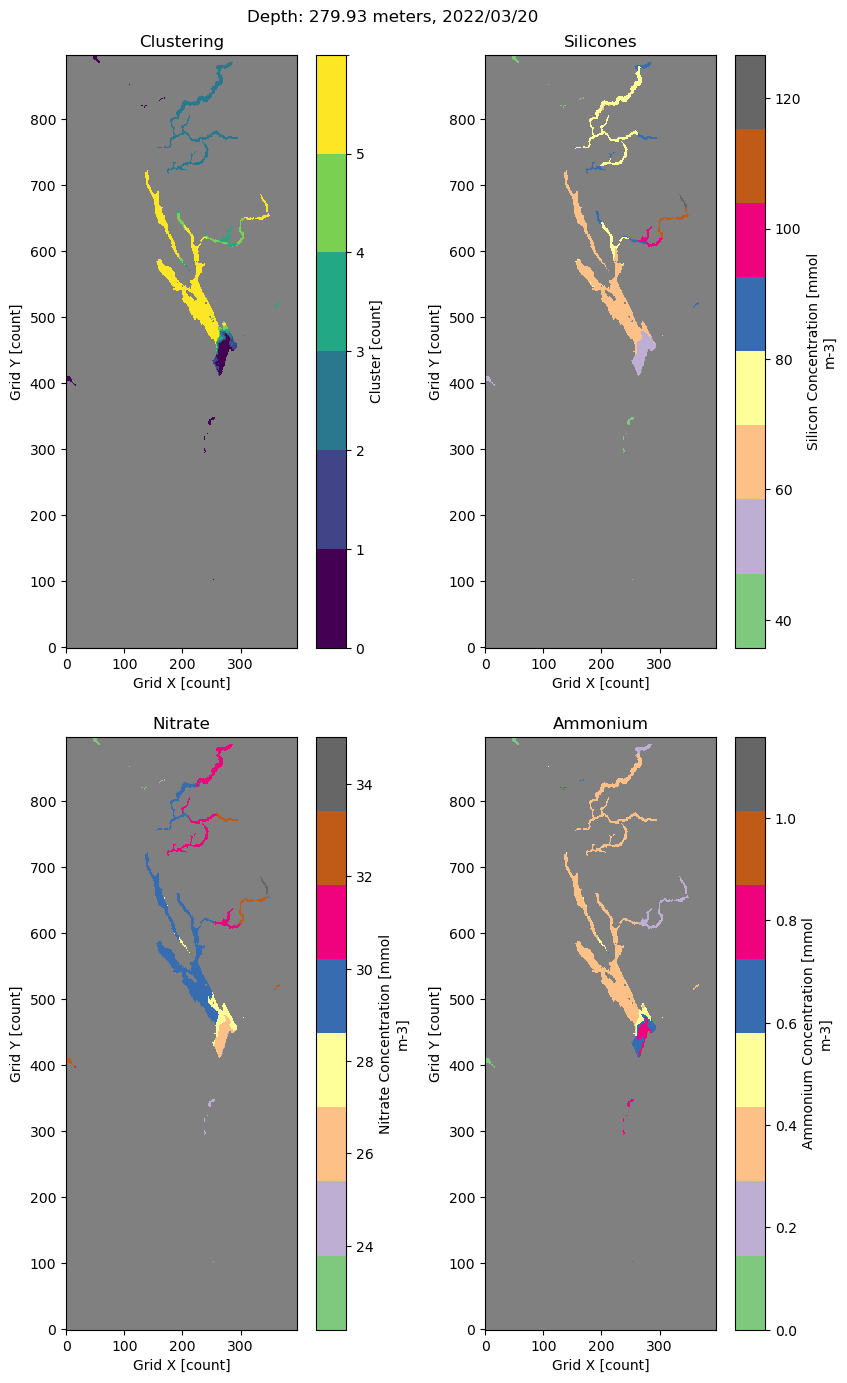

The amount of grid boxes for cluster 0 is 1307 

The minimum temperature for cluster 0 is 9.29 degrees Celsius
The maximum temperature for cluster 0 is 9.41 degrees Celsius
The mean temperature for cluster 0 is 9.37 degrees Celsius 

The minimum salinity for cluster 0 is 30.76 g/kg
The maximum salinity for cluster 0 is 31.11 g/kg
The mean salinity for cluster 0 is 30.94 g/kg 


The amount of grid boxes for cluster 1 is 3430 

The minimum temperature for cluster 1 is 9.37 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 9.42 degrees Celsius 

The minimum salinity for cluster 1 is 31.07 g/kg
The maximum salinity for cluster 1 is 31.15 g/kg
The mean salinity for cluster 1 is 31.12 g/kg 


The amount of grid boxes for cluster 2 is 318 

The minimum temperature for cluster 2 is 9.05 degrees Celsius
The maximum temperature for cluster 2 is 9.23 degrees Celsius
The mean temperature for cluster 2 is 9.09 degrees Celsius 

The m

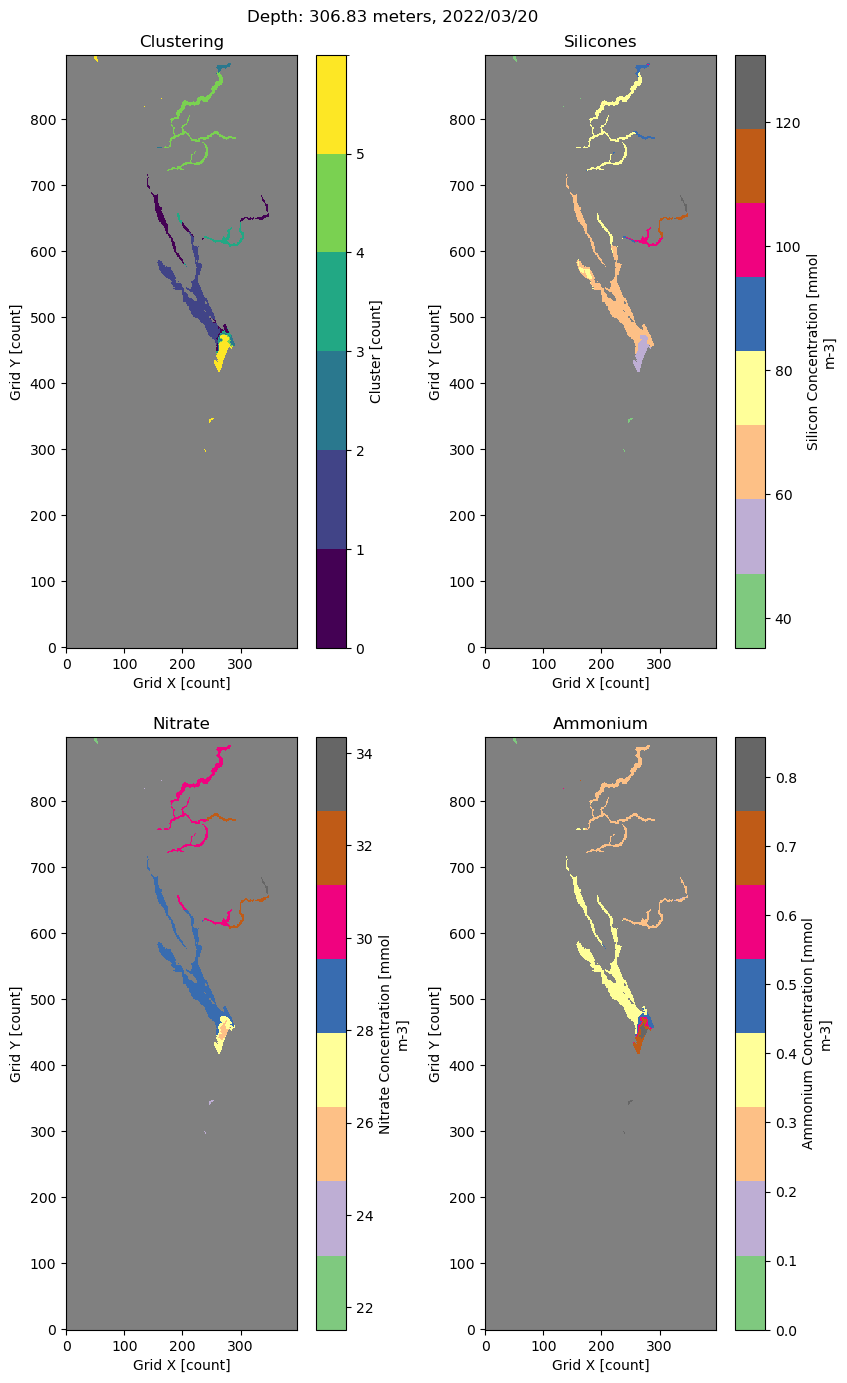

The amount of grid boxes for cluster 0 is 1800 

The minimum temperature for cluster 0 is 8.9 degrees Celsius
The maximum temperature for cluster 0 is 9.08 degrees Celsius
The mean temperature for cluster 0 is 9.0 degrees Celsius 

The minimum salinity for cluster 0 is 30.67 g/kg
The maximum salinity for cluster 0 is 31.05 g/kg
The mean salinity for cluster 0 is 30.73 g/kg 


The amount of grid boxes for cluster 1 is 445 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 8.88 degrees Celsius
The mean temperature for cluster 1 is 8.42 degrees Celsius 

The minimum salinity for cluster 1 is 30.84 g/kg
The maximum salinity for cluster 1 is 31.47 g/kg
The mean salinity for cluster 1 is 30.97 g/kg 


The amount of grid boxes for cluster 2 is 696 

The minimum temperature for cluster 2 is 9.19 degrees Celsius
The maximum temperature for cluster 2 is 9.31 degrees Celsius
The mean temperature for cluster 2 is 9.25 degrees Celsius 

The mini

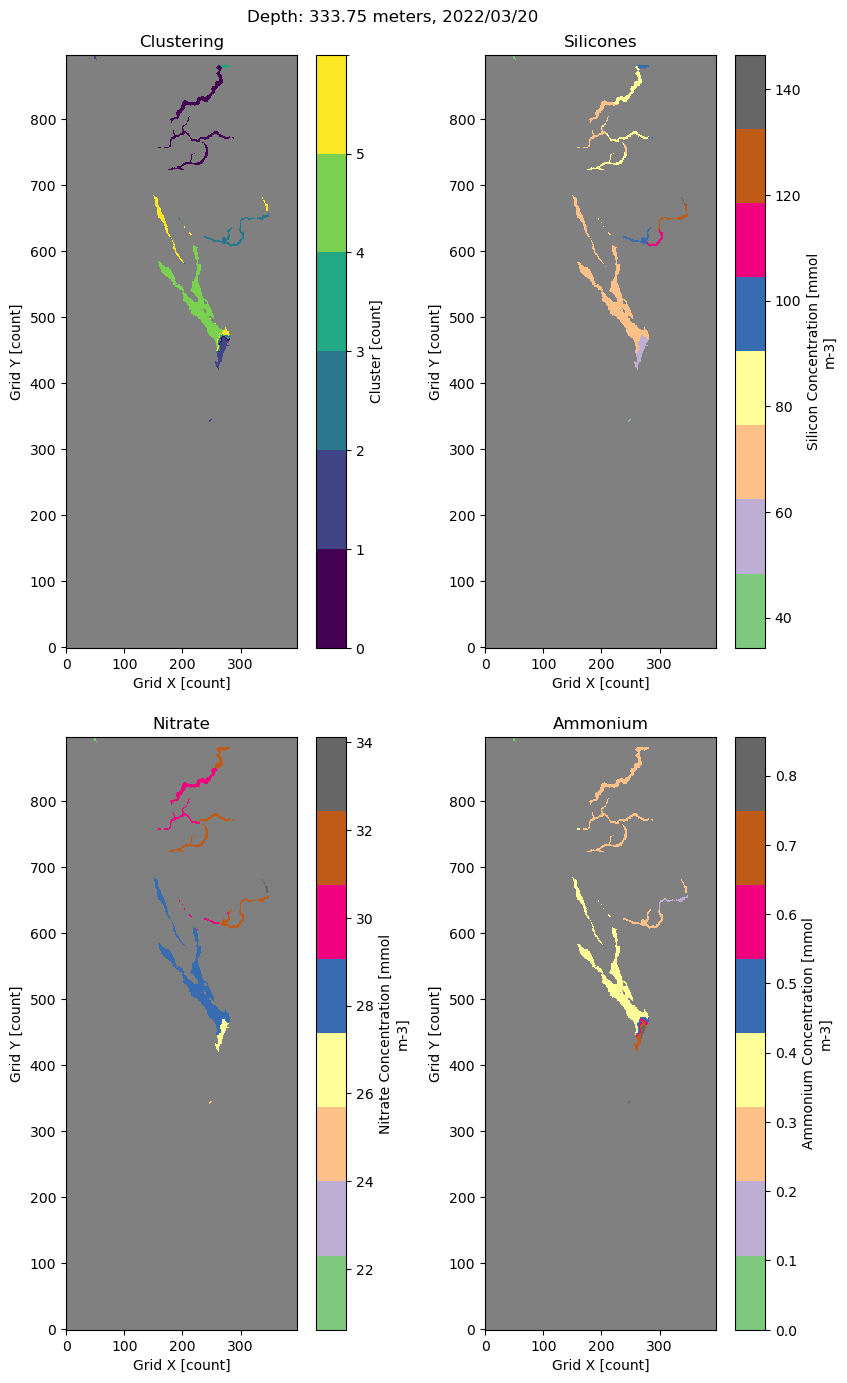

The amount of grid boxes for cluster 0 is 2031 

The minimum temperature for cluster 0 is 9.41 degrees Celsius
The maximum temperature for cluster 0 is 9.46 degrees Celsius
The mean temperature for cluster 0 is 9.44 degrees Celsius 

The minimum salinity for cluster 0 is 31.1 g/kg
The maximum salinity for cluster 0 is 31.18 g/kg
The mean salinity for cluster 0 is 31.16 g/kg 


The amount of grid boxes for cluster 1 is 262 

The minimum temperature for cluster 1 is 9.35 degrees Celsius
The maximum temperature for cluster 1 is 9.41 degrees Celsius
The mean temperature for cluster 1 is 9.39 degrees Celsius 

The minimum salinity for cluster 1 is 30.85 g/kg
The maximum salinity for cluster 1 is 31.14 g/kg
The mean salinity for cluster 1 is 31.0 g/kg 


The amount of grid boxes for cluster 2 is 336 

The minimum temperature for cluster 2 is 9.24 degrees Celsius
The maximum temperature for cluster 2 is 9.35 degrees Celsius
The mean temperature for cluster 2 is 9.28 degrees Celsius 

The mini

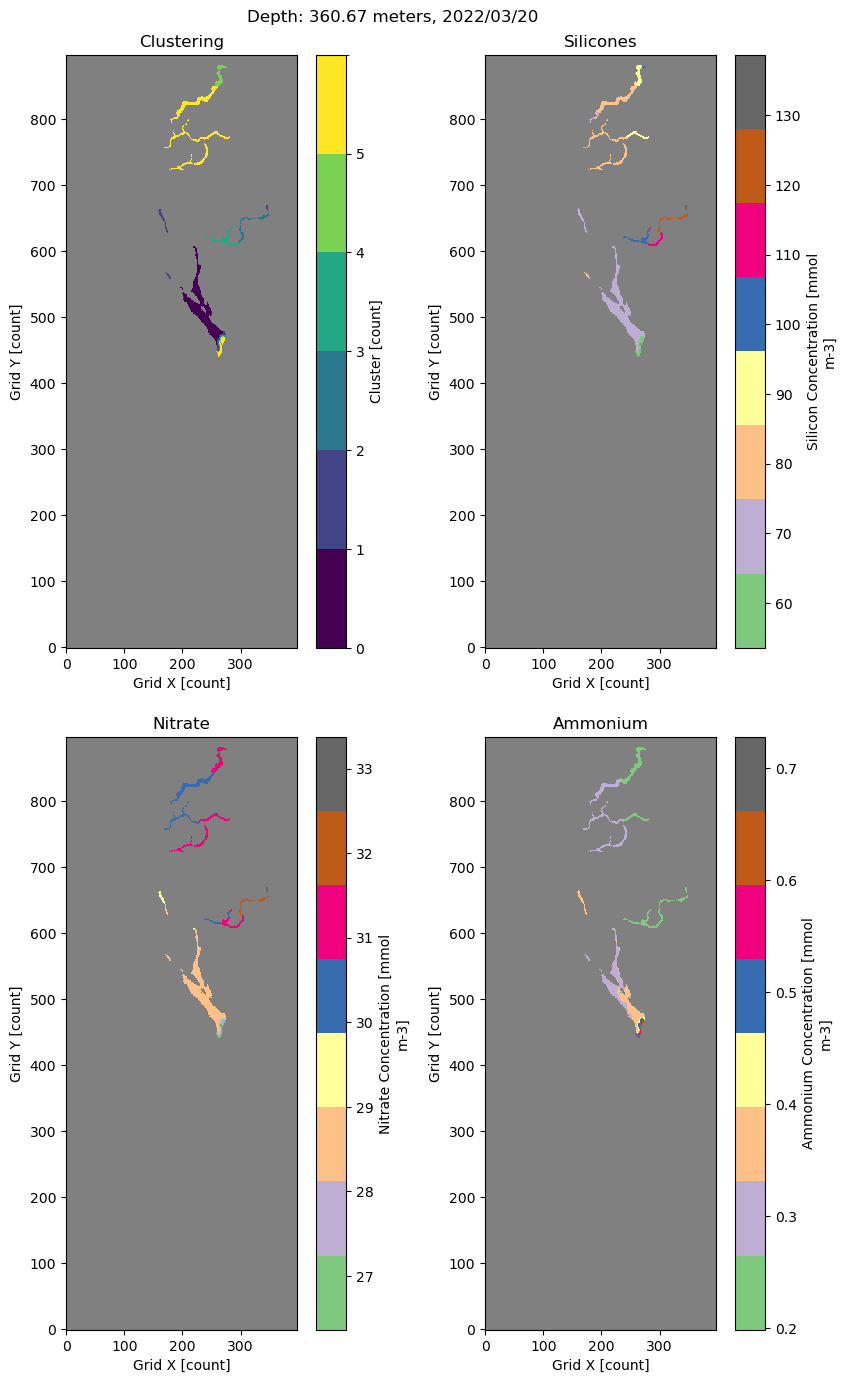

The amount of grid boxes for cluster 0 is 223 

The minimum temperature for cluster 0 is 9.05 degrees Celsius
The maximum temperature for cluster 0 is 9.09 degrees Celsius
The mean temperature for cluster 0 is 9.07 degrees Celsius 

The minimum salinity for cluster 0 is 30.74 g/kg
The maximum salinity for cluster 0 is 31.07 g/kg
The mean salinity for cluster 0 is 30.75 g/kg 


The amount of grid boxes for cluster 1 is 1184 

The minimum temperature for cluster 1 is 8.91 degrees Celsius
The maximum temperature for cluster 1 is 9.06 degrees Celsius
The mean temperature for cluster 1 is 9.0 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 30.77 g/kg
The mean salinity for cluster 1 is 30.73 g/kg 


The amount of grid boxes for cluster 2 is 291 

The minimum temperature for cluster 2 is 9.23 degrees Celsius
The maximum temperature for cluster 2 is 9.34 degrees Celsius
The mean temperature for cluster 2 is 9.28 degrees Celsius 

The min

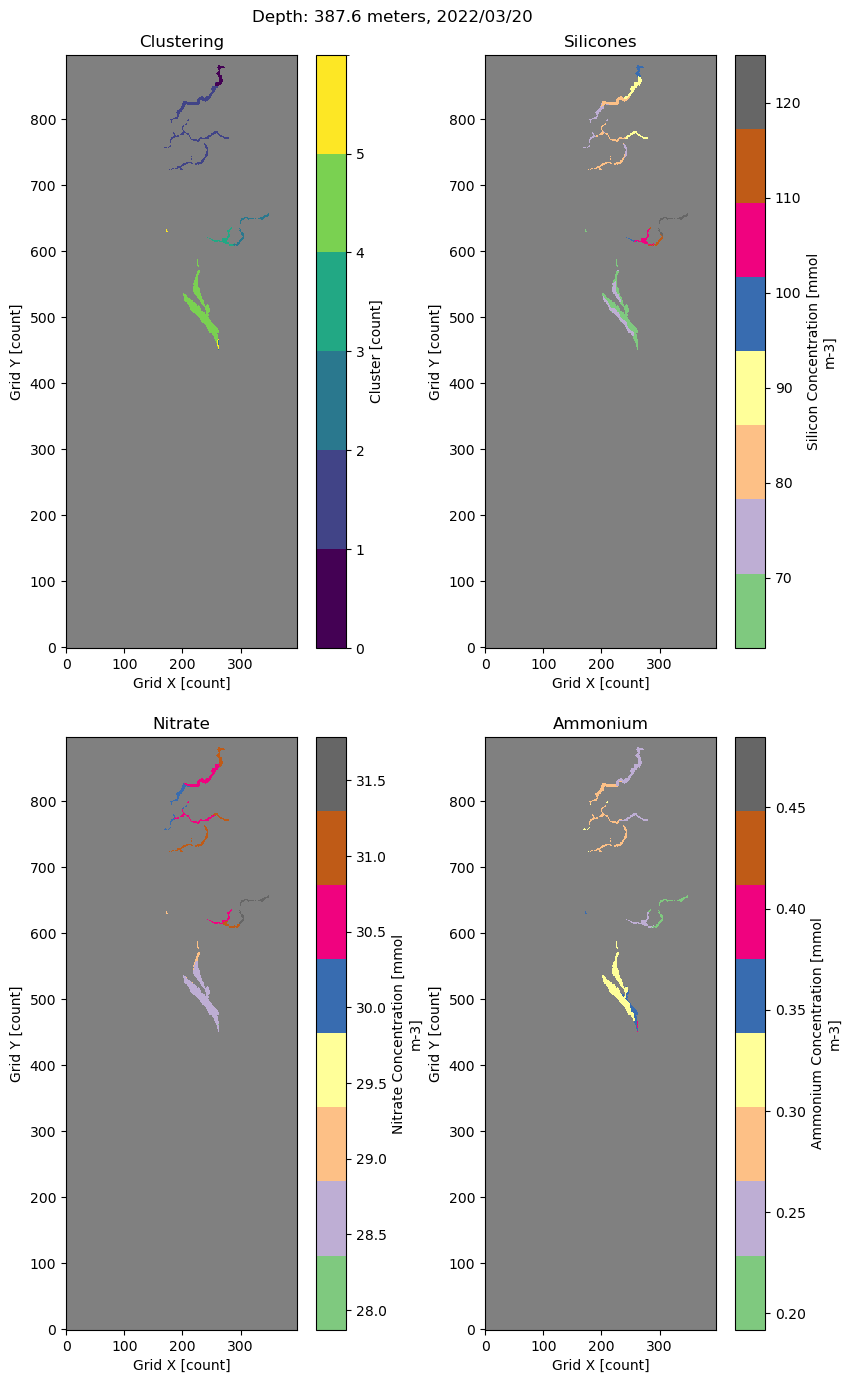

The amount of grid boxes for cluster 0 is 140 

The minimum temperature for cluster 0 is 9.29 degrees Celsius
The maximum temperature for cluster 0 is 9.3 degrees Celsius
The mean temperature for cluster 0 is 9.3 degrees Celsius 

The minimum salinity for cluster 0 is 31.12 g/kg
The maximum salinity for cluster 0 is 31.13 g/kg
The mean salinity for cluster 0 is 31.13 g/kg 


The amount of grid boxes for cluster 1 is 677 

The minimum temperature for cluster 1 is 9.43 degrees Celsius
The maximum temperature for cluster 1 is 9.46 degrees Celsius
The mean temperature for cluster 1 is 9.44 degrees Celsius 

The minimum salinity for cluster 1 is 31.15 g/kg
The maximum salinity for cluster 1 is 31.19 g/kg
The mean salinity for cluster 1 is 31.18 g/kg 


The amount of grid boxes for cluster 3 is 906 

The minimum temperature for cluster 3 is 9.2 degrees Celsius
The maximum temperature for cluster 3 is 9.29 degrees Celsius
The mean temperature for cluster 3 is 9.22 degrees Celsius 

The minimu

IndexError: index 5 is out of bounds for axis 0 with size 5

In [14]:
ds, temp, saline, date, mask, sil, nitr, ammo = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, nitr, ammo = masking(depth, temp, saline, mask, sil, nitr, ammo)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, sil, nitr, ammo)
